TODO:
1. Reduce feature used

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression,BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [2]:
df_raw = pd.read_parquet("AvailabilityDataCombined.gzip")

In [3]:
df = df_raw.loc[df_raw["last_update"] > pd.to_datetime("2024-02-15 09:40:00")]

In [4]:
# featuresList = ["number","last_update","available_bikes","banking","temp","feels_like","pressure","humidity","uvi","clouds","visibility","wind_speed","wind_gust","weather_main","rain","snow","weather_description"]
featuresList = ["number","last_update","available_bikes","banking","temp","feels_like","pressure","humidity","uvi","clouds","visibility","wind_speed","wind_gust","weather_main","rain","weather_description"]
df = df[featuresList]

In [5]:
df

number         last_update  available_bikes  banking    temp  \
119           1 2024-02-15 09:41:35               14        0  285.22   
120           1 2024-02-15 09:44:55               15        0  285.22   
121           1 2024-02-15 09:50:05               15        0  285.22   
122           1 2024-02-15 09:55:07               16        0  285.22   
123           1 2024-02-15 10:01:25               17        0  285.22   
...         ...                 ...              ...      ...     ...   
1046548     117 2024-04-06 11:21:15                2        0  286.54   
1046549     117 2024-04-06 11:31:21                2        0  286.54   
1046550     117 2024-04-06 11:41:26                2        0  285.98   
1046551     117 2024-04-06 11:51:30                2        0  285.98   
1046552     117 2024-04-06 12:01:36                2        0  285.43   

         feels_like  pressure  humidity   uvi  clouds  visibility  wind_speed  \
119          285.07      1002        99  0.11     100         265        6.24   
120          285.07      1002        99  0.11     100         265        6.24   
121          285.07      1002        99  0.11     100         265        6.24   
122          285.07      1002        99  0.11     100         265        6.24   
123          285.07      1002        99  0.11     100         265        6.24   
...             ...       ...       ...   ...     ...         ...         ...   
1046548      286.05       986        81  0.60     100       10000       17.14   
1046549      286.05       986        81  0.60     100       10000       17.14   
1046550      285.51       987        84  2.95     100       10000       17.67   
1046551      285.56       987        86  2.95     100       10000       17.67   
1046552      284.96       987        86  2.95     100       10000       17.67   

         wind_gust weather_main  rain weather_description  
119          10.71       Clouds  None     overcast clouds  
120          10.71       Clouds  None     overcast clouds  
121          10.71       Clouds  None     overcast clouds  
122          10.71       Clouds  None     overcast clouds  
123          10.71       Clouds  None     overcast clouds  
...            ...          ...   ...                 ...  
1046548      25.10       Clouds  None     overcast clouds  
1046549      25.10       Clouds  None     overcast clouds  
1046550      25.70       Clouds  None     overcast clouds  
1046551      25.70       Clouds  None     overcast clouds  
1046552      25.70         Rain  0.18          light rain  

[1033869 rows x 16 columns]

In [6]:
def addHourDayMonth(dfX):
    # Convert 'last_update' to datetime and extract useful features
    dfX['last_update'] = pd.to_datetime(dfX['last_update'])
    dfX['hour'] = dfX['last_update'].dt.hour
    dfX['day'] = dfX['last_update'].dt.day
    dfX['day_of_week'] = dfX['last_update'].dt.dayofweek
    dfX['month'] = dfX['last_update'].dt.month
    dfX = dfX.drop(['last_update'], axis=1,inplace=True)

C:\Users\Visky\AppData\Local\Temp\ipykernel_26844\28852729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfX['last_update'] = pd.to_datetime(dfX['last_update'])
C:\Users\Visky\AppData\Local\Temp\ipykernel_26844\28852729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfX['hour'] = dfX['last_update'].dt.hour
C:\Users\Visky\AppData\Local\Temp\ipykernel_26844\28852729.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

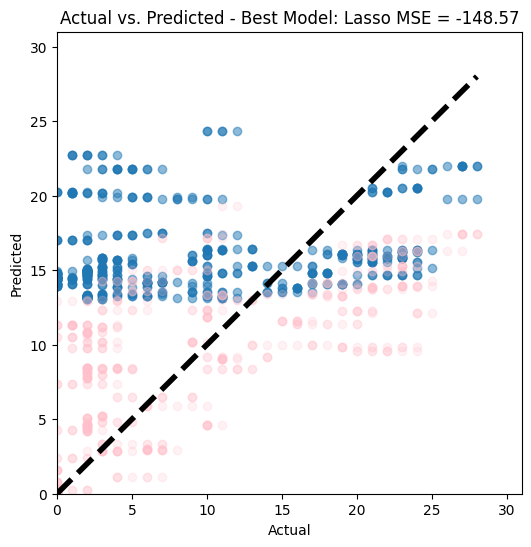

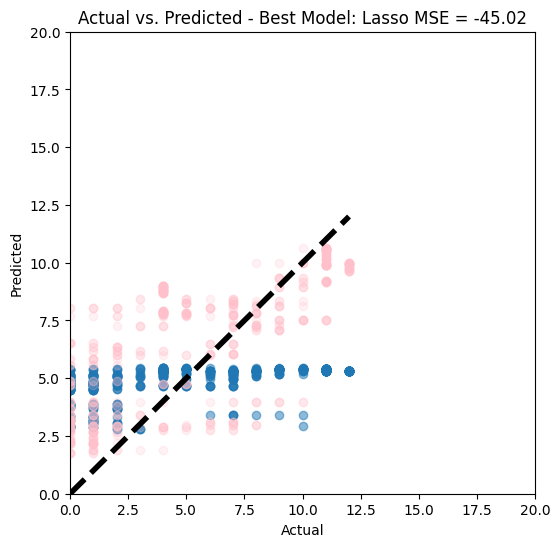

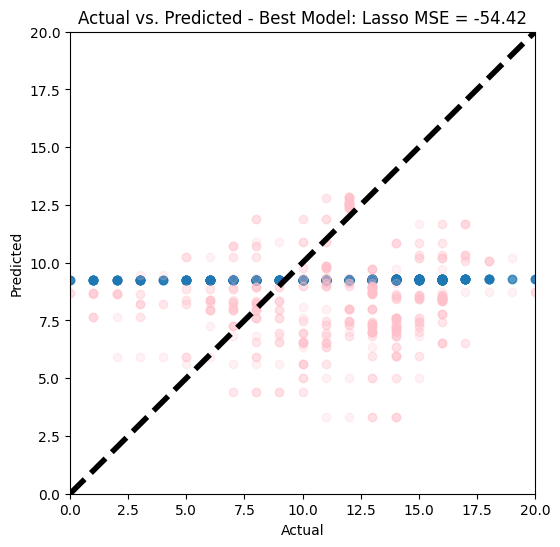

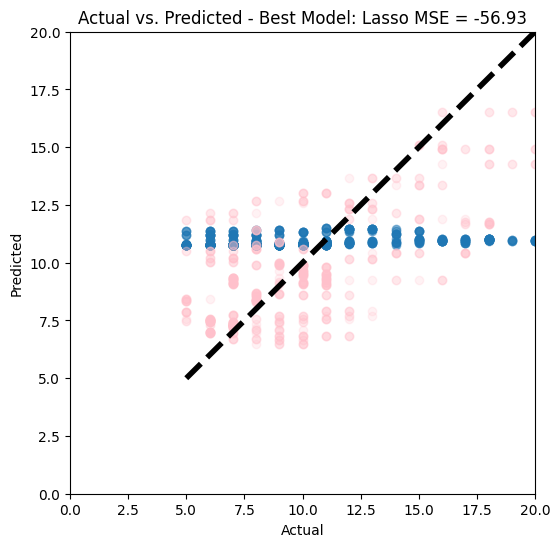

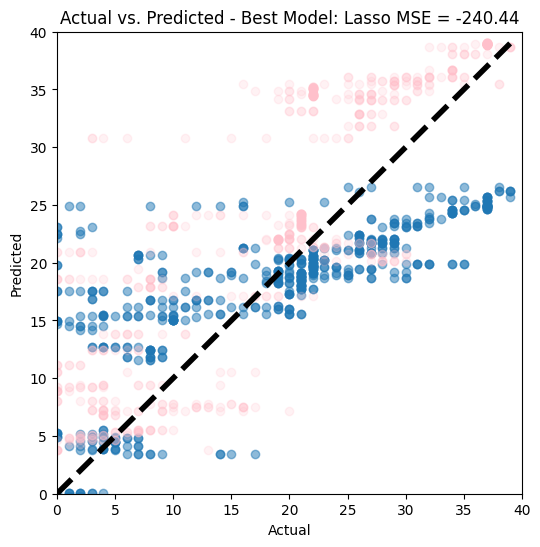

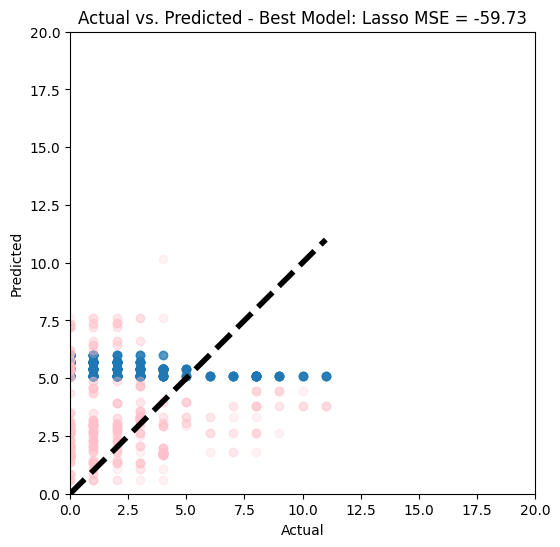

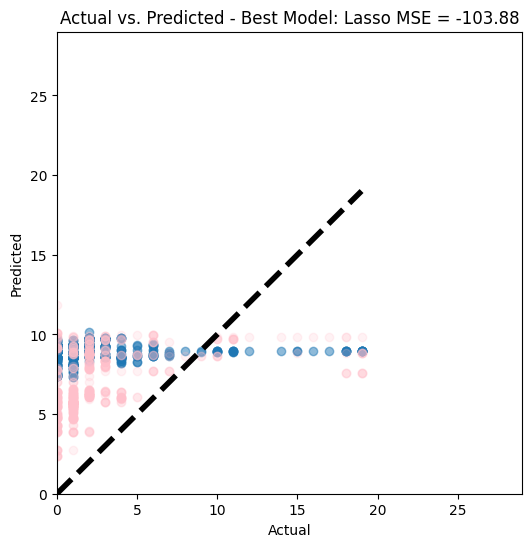

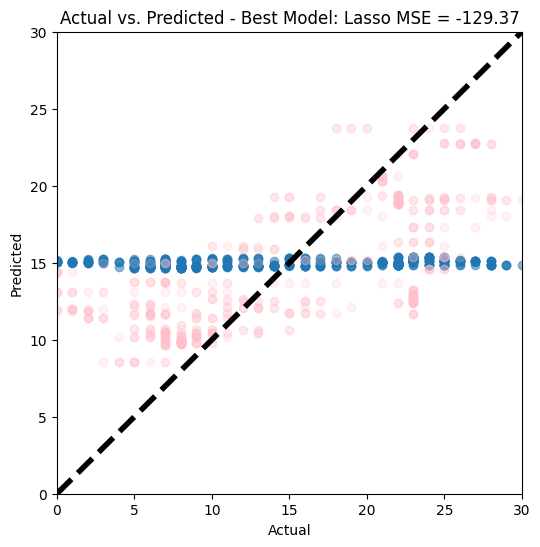

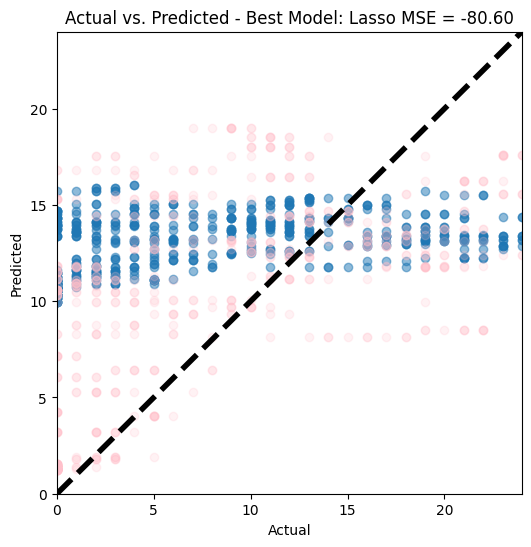

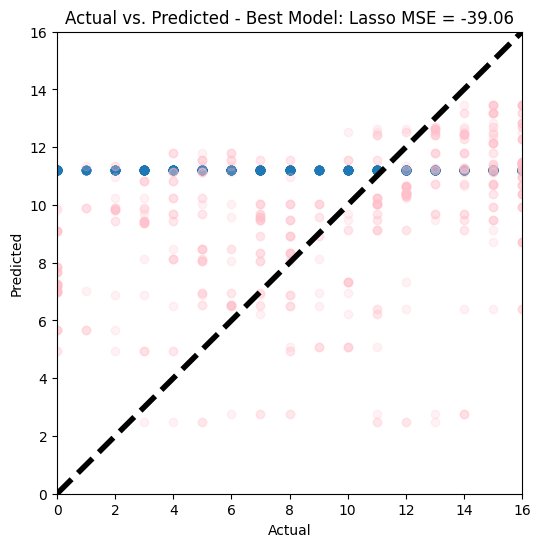

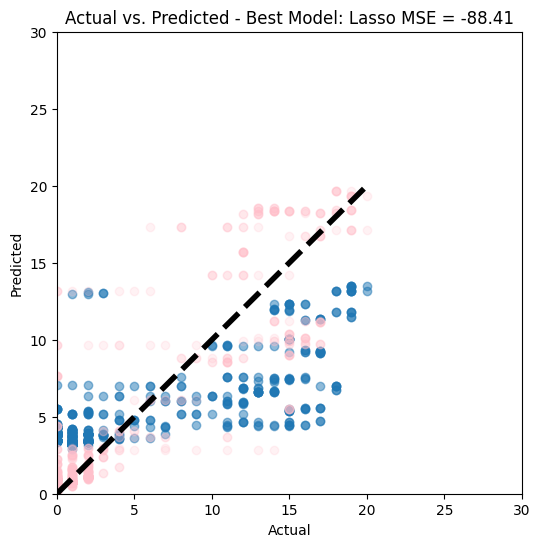

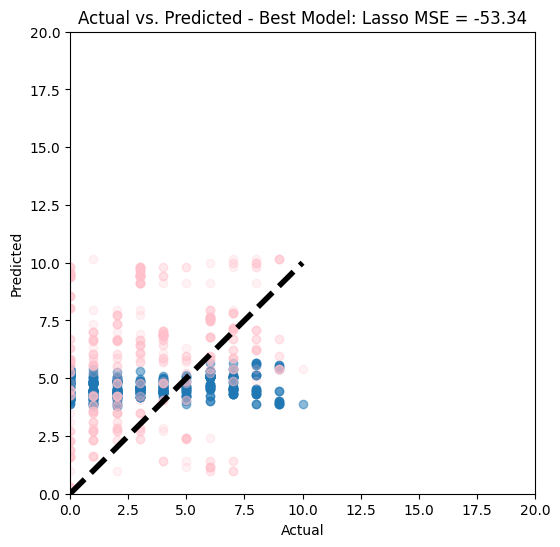

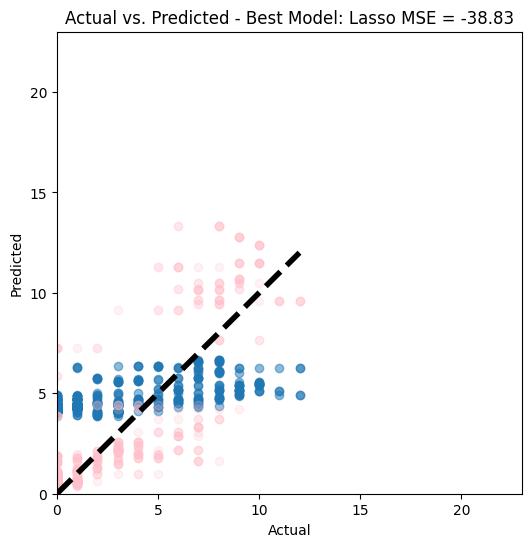

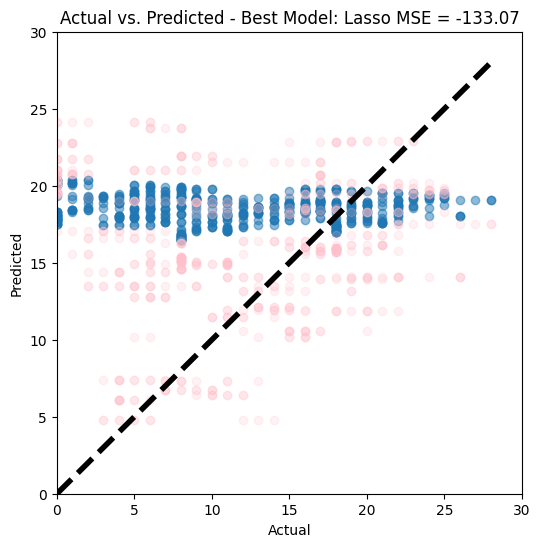

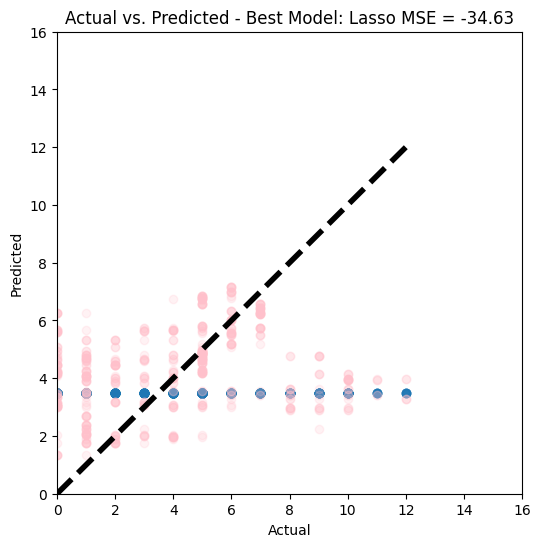

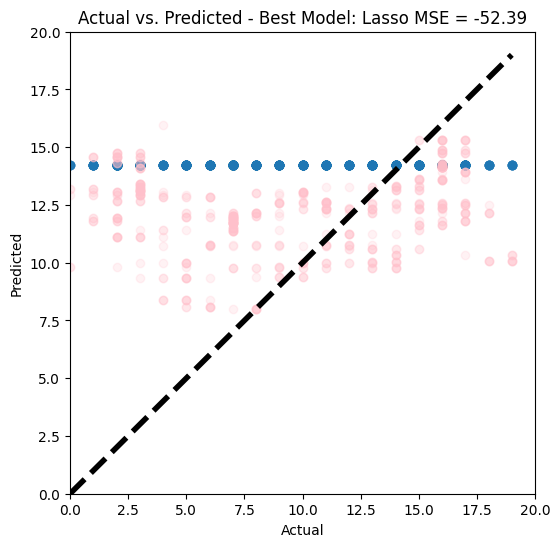

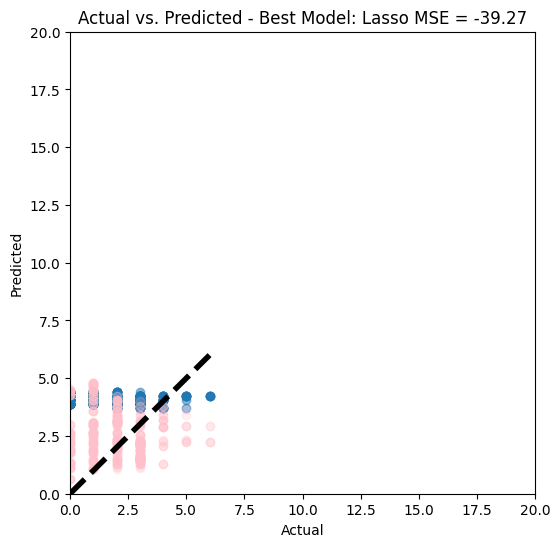

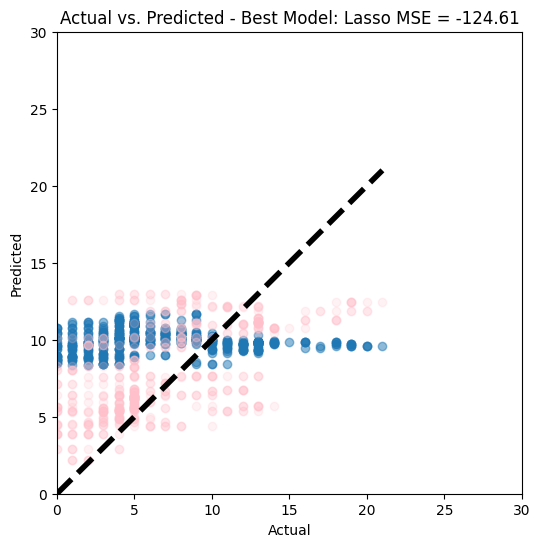

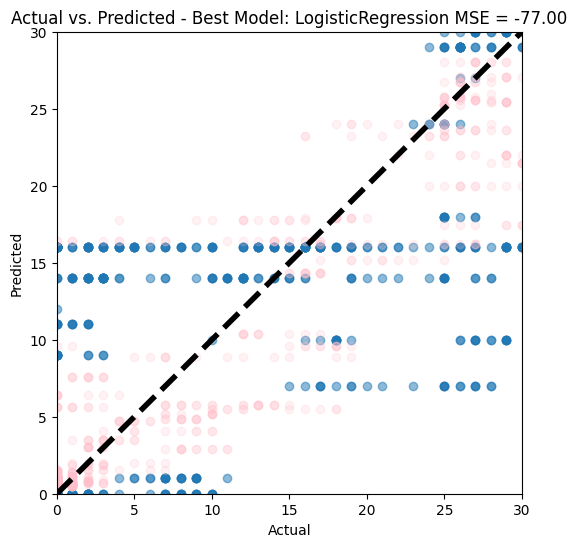

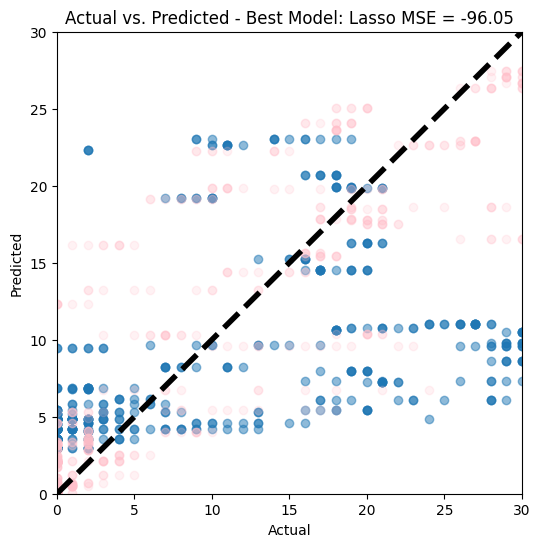

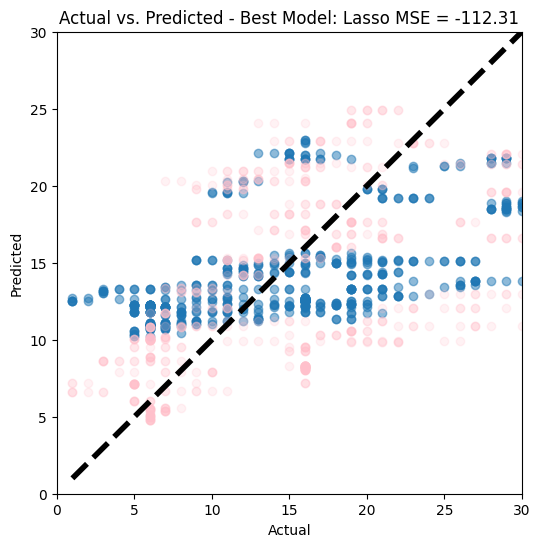

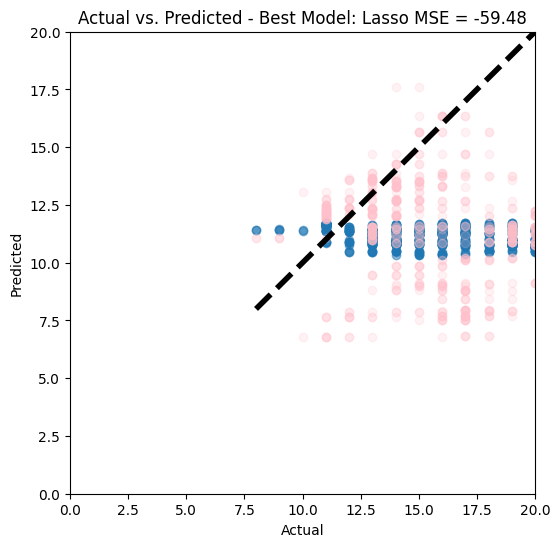

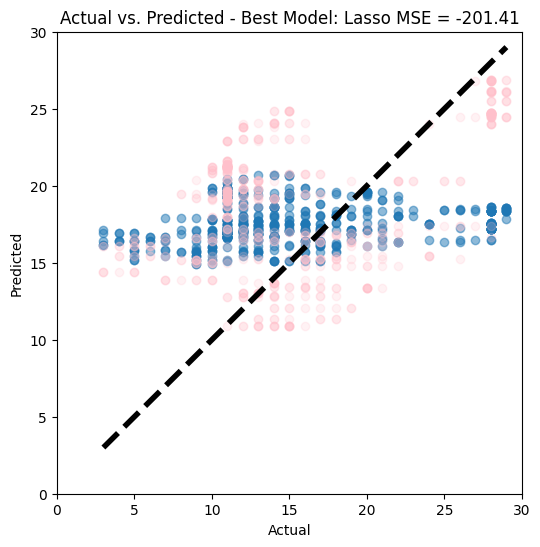

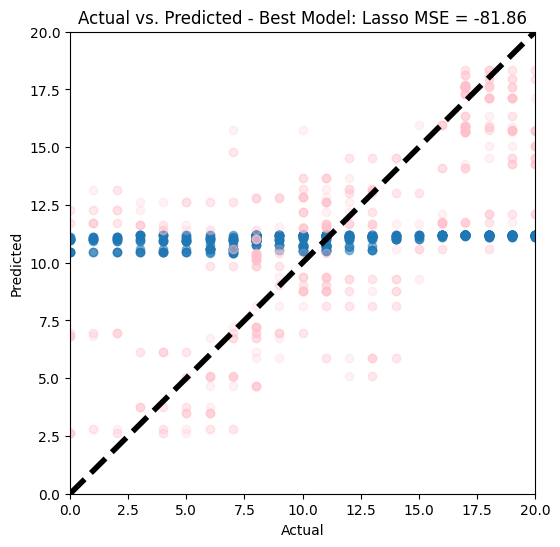

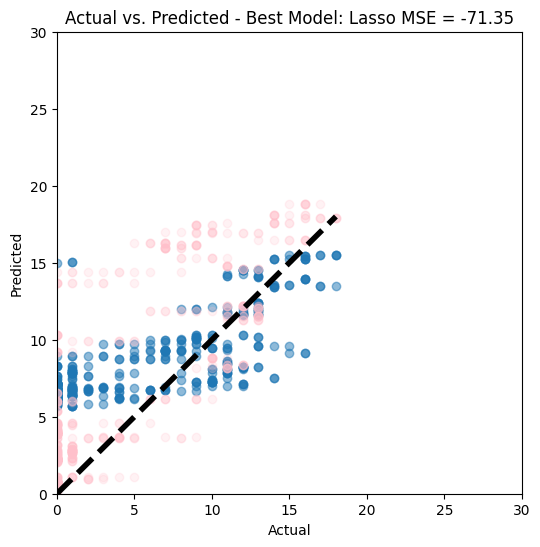

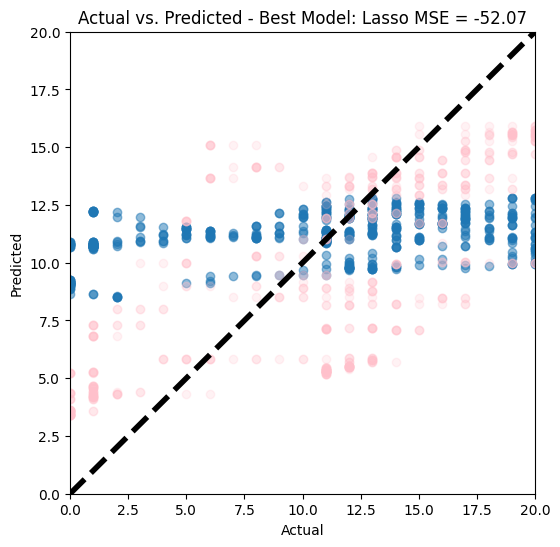

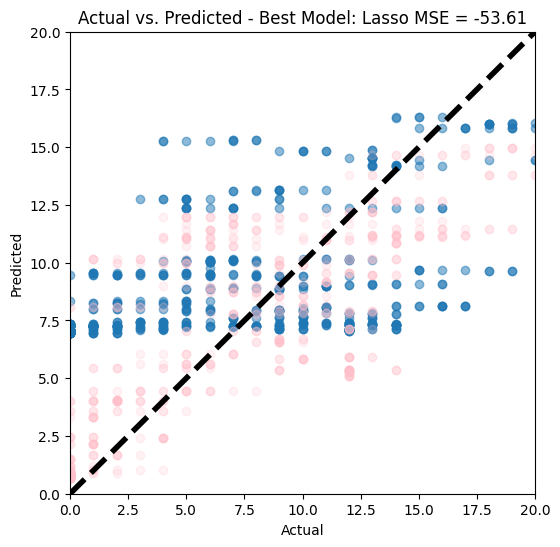

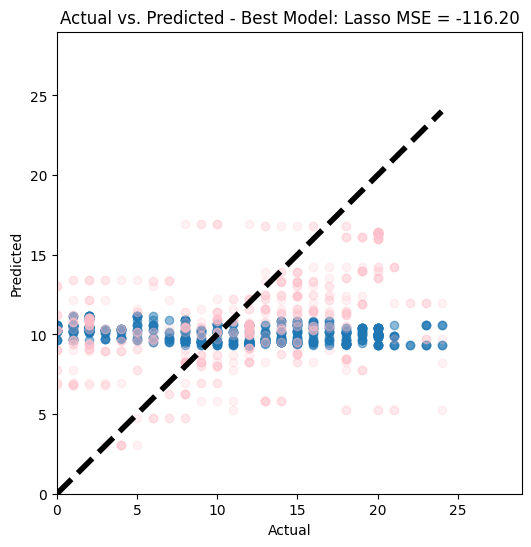

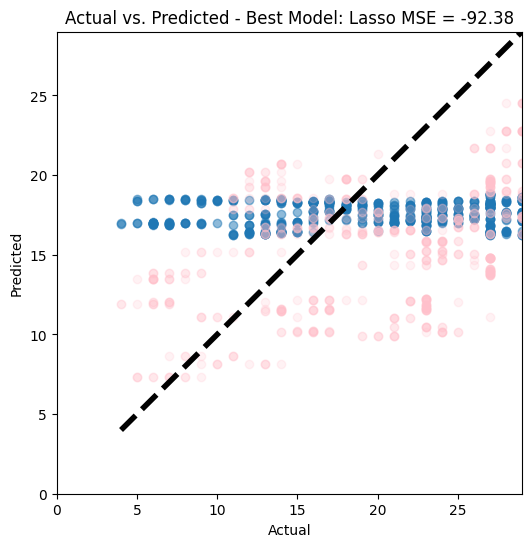

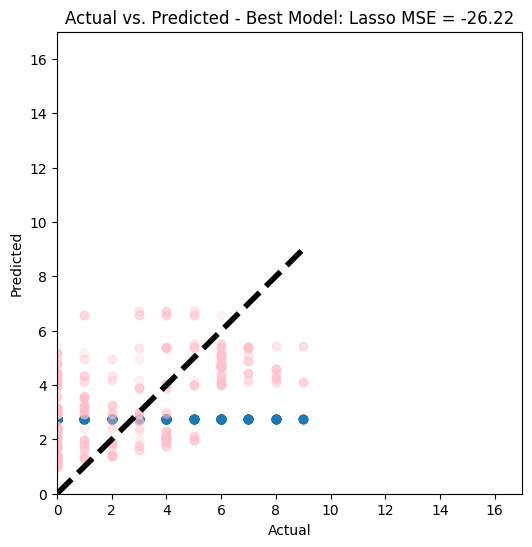

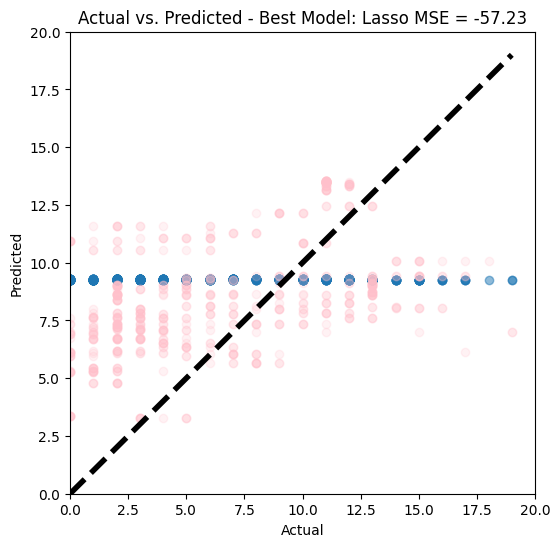

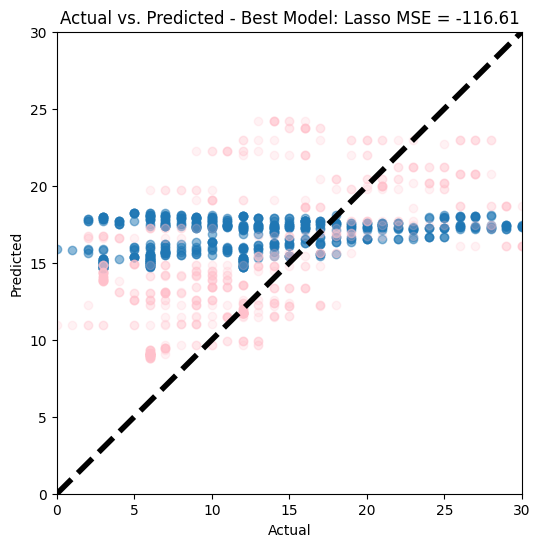

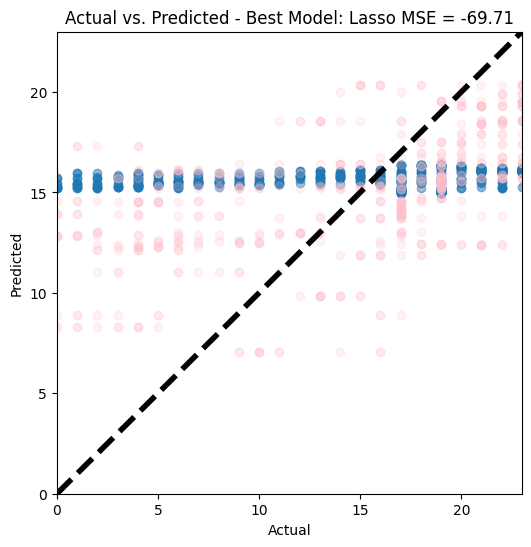

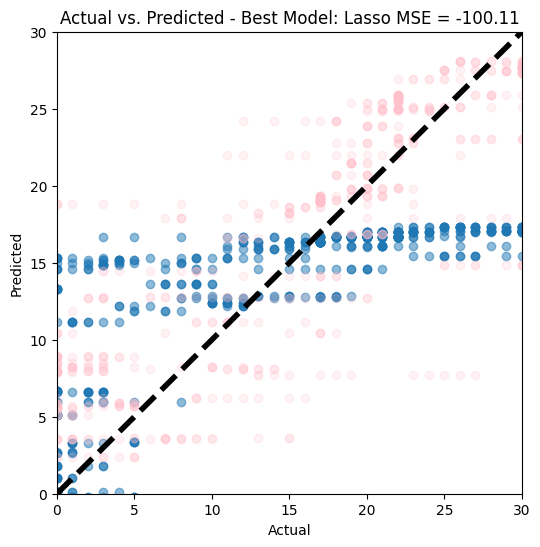

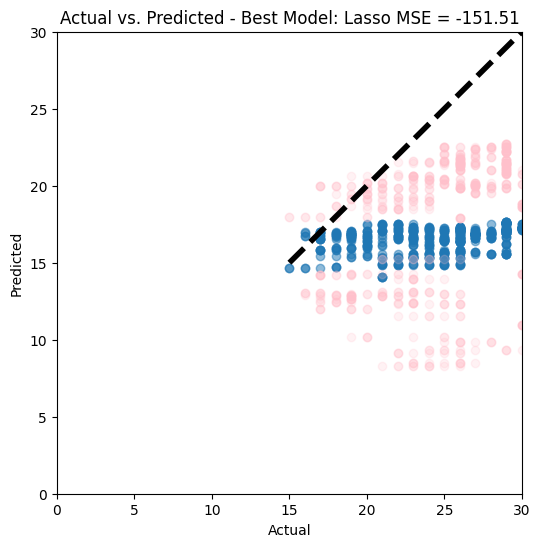

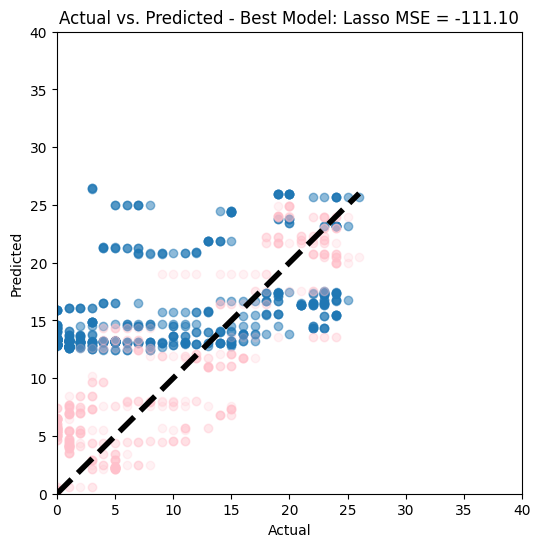

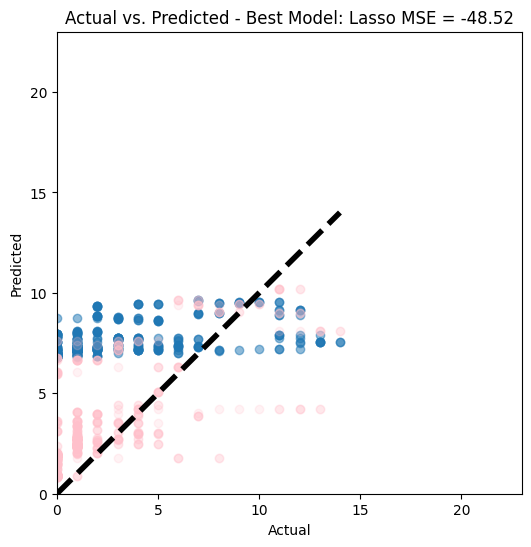

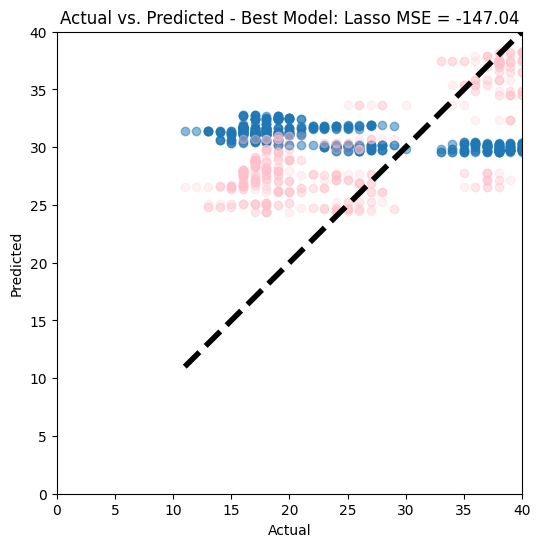

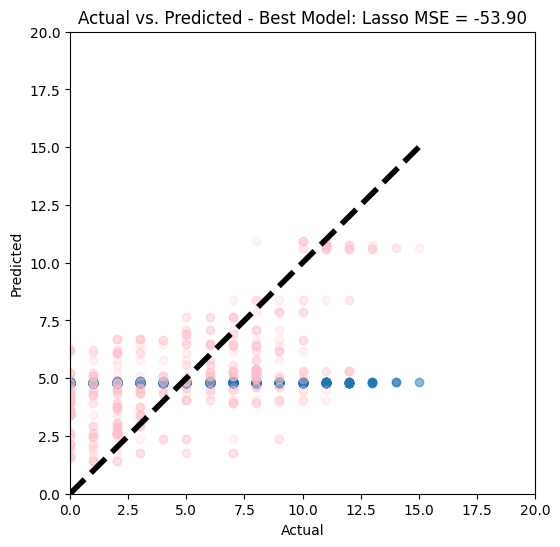

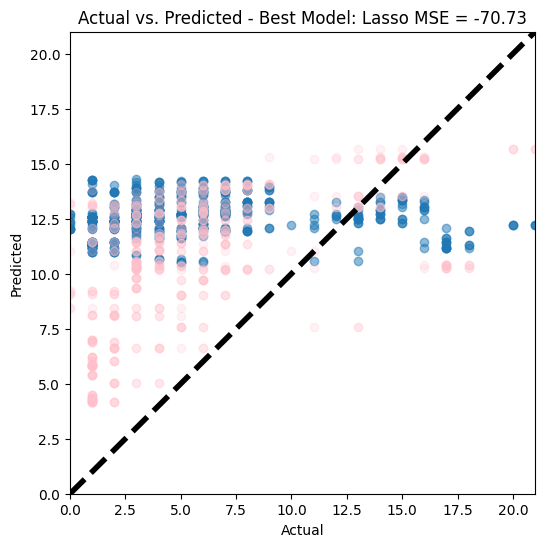

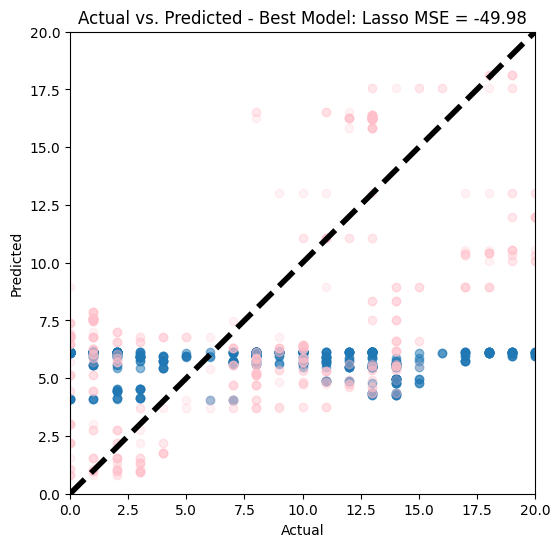

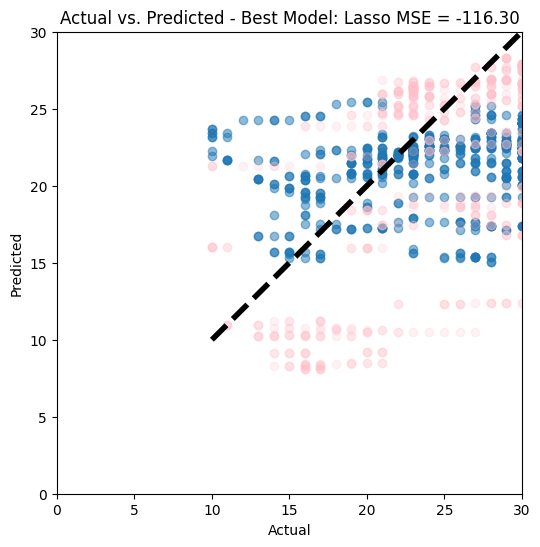

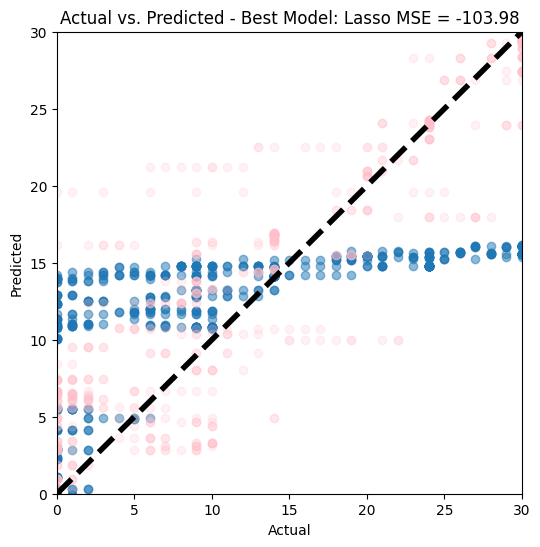

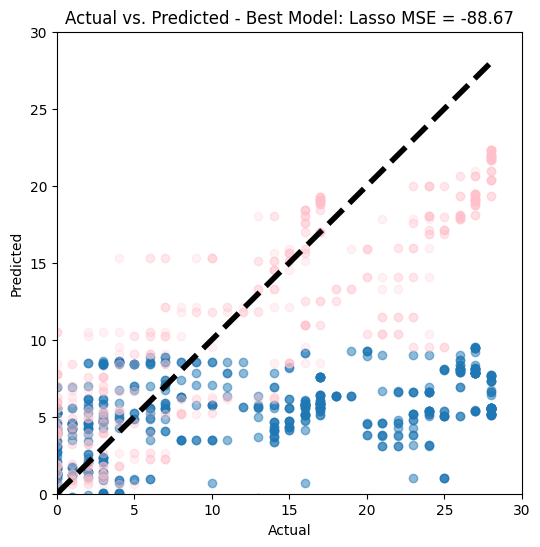

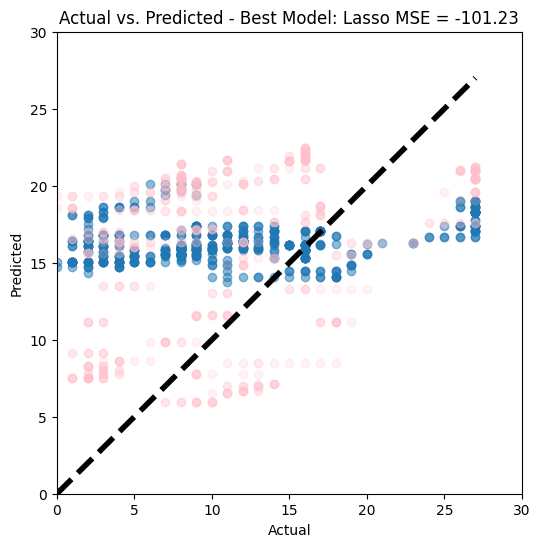

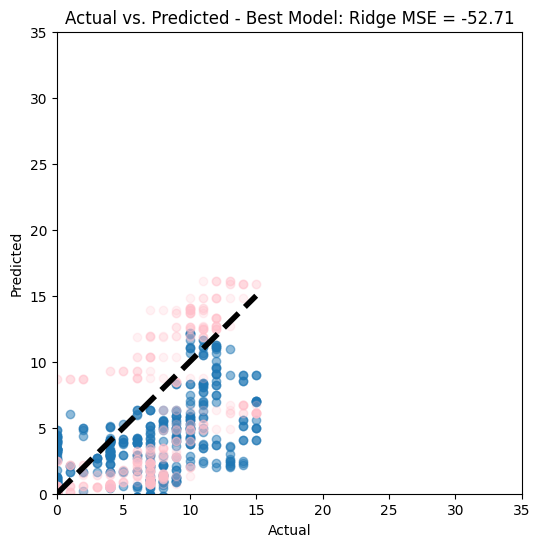

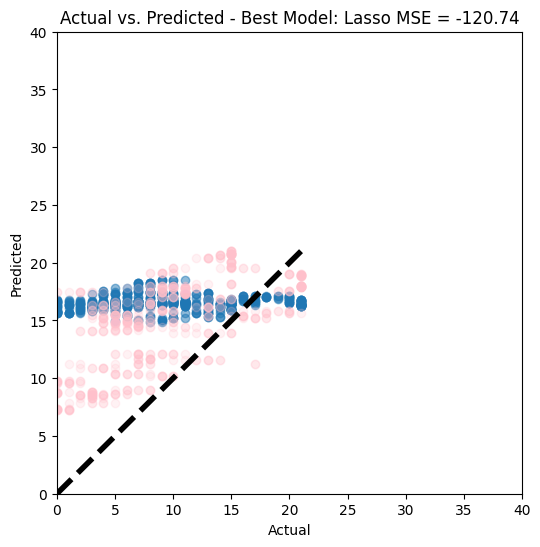

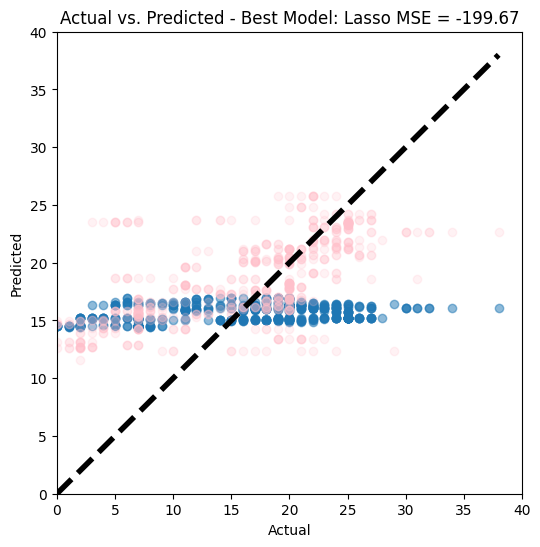

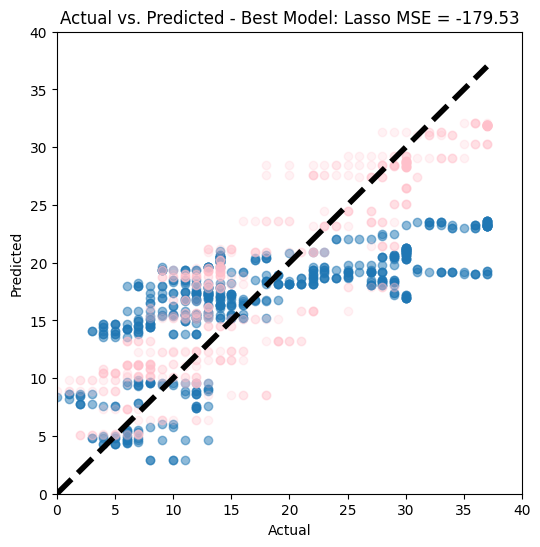

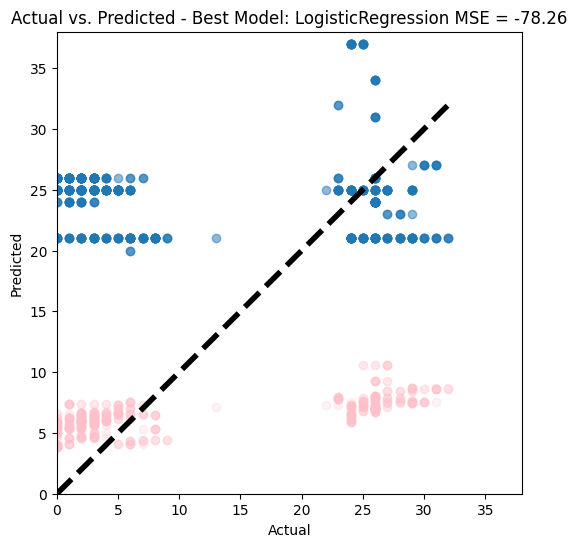

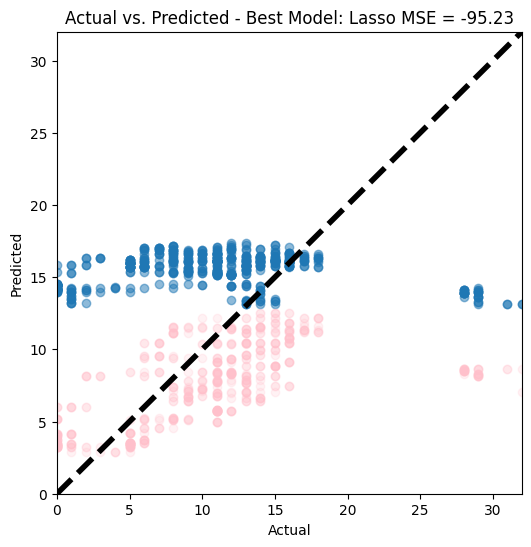

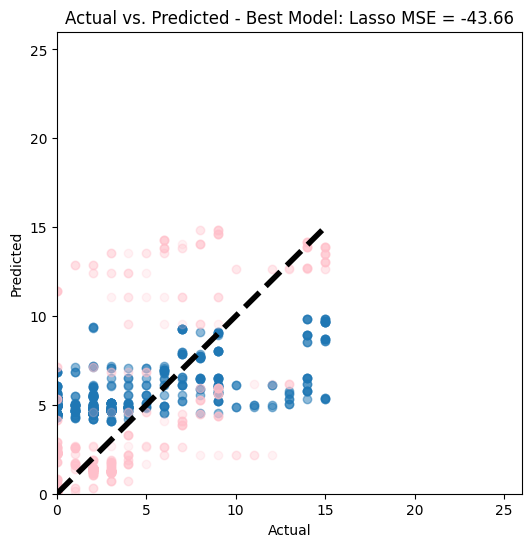

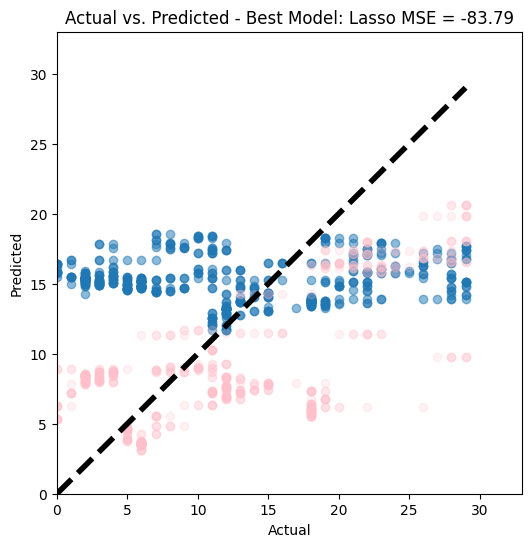

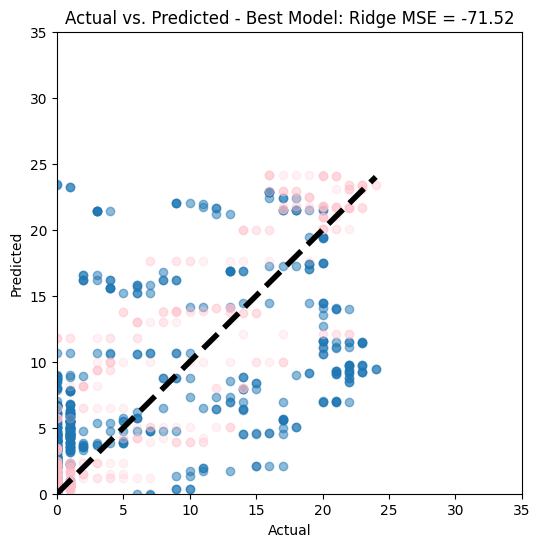

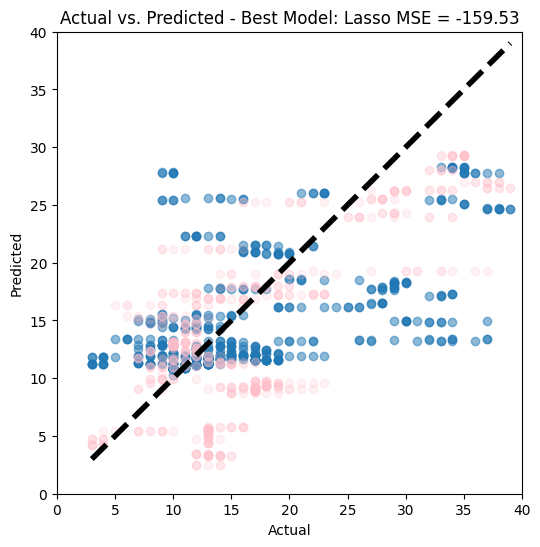

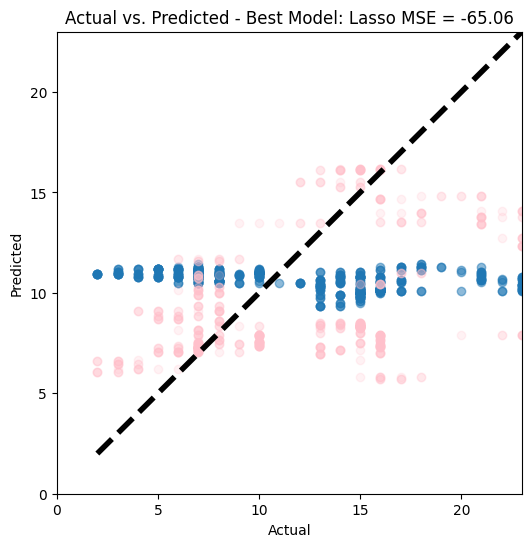

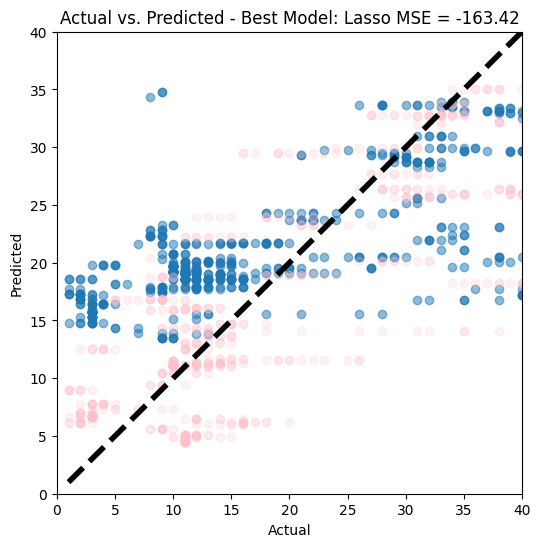

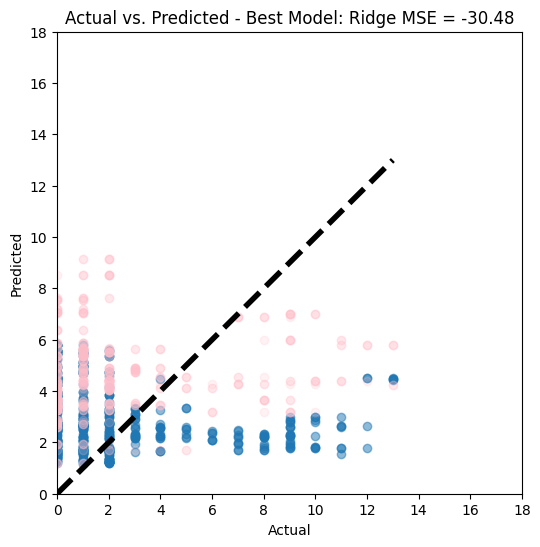

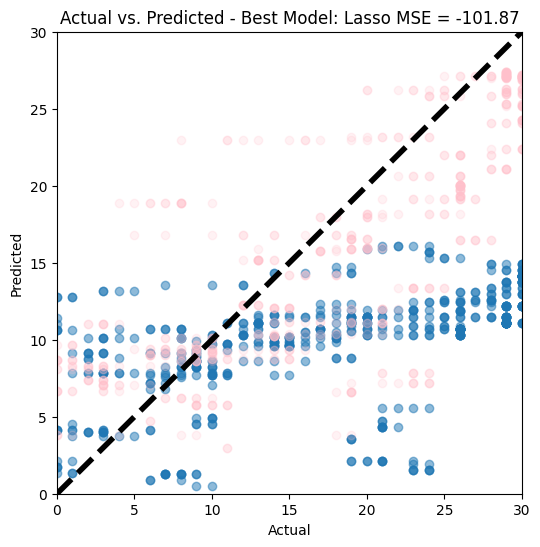

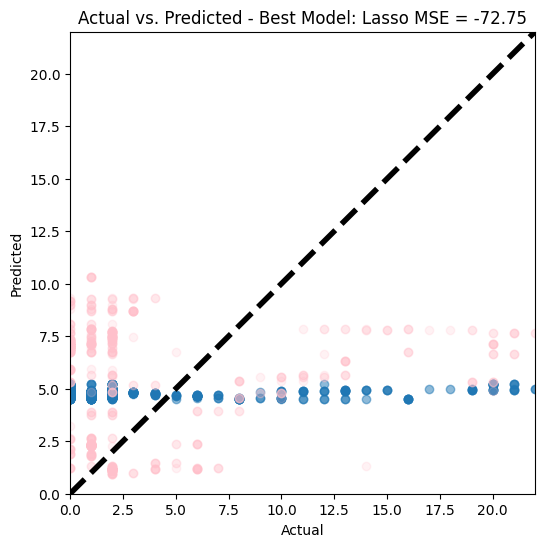

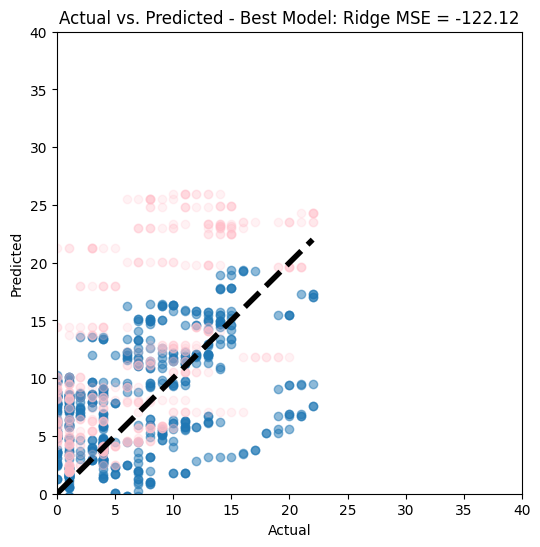

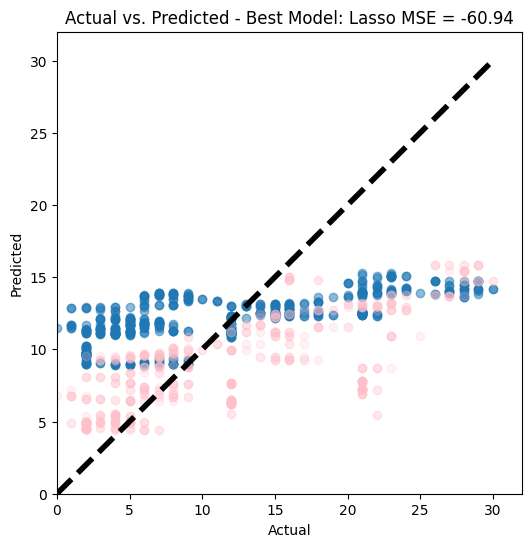

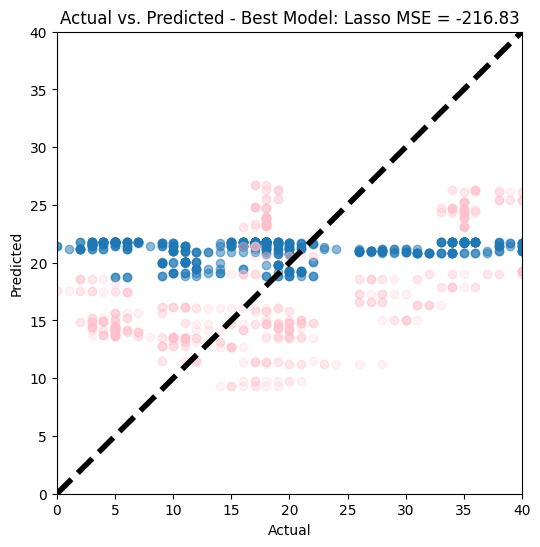

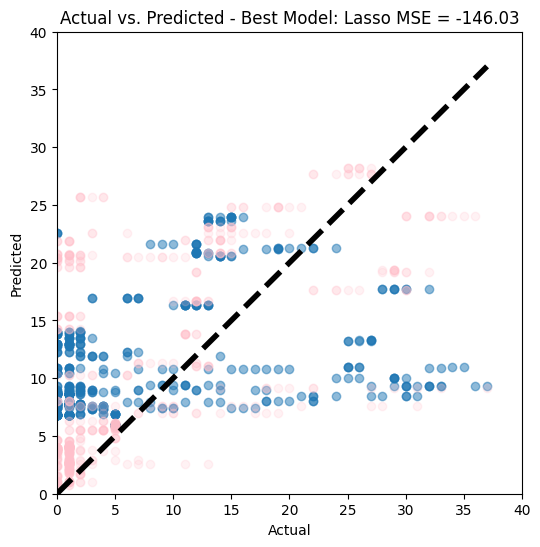

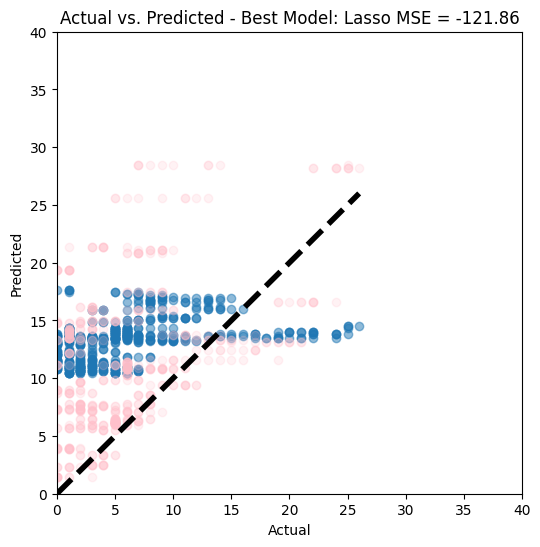

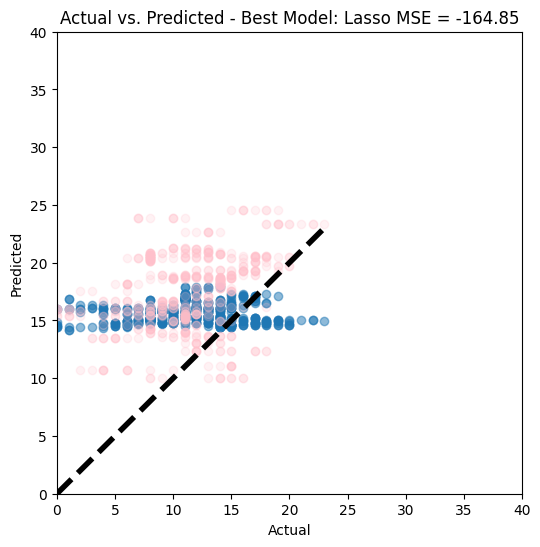

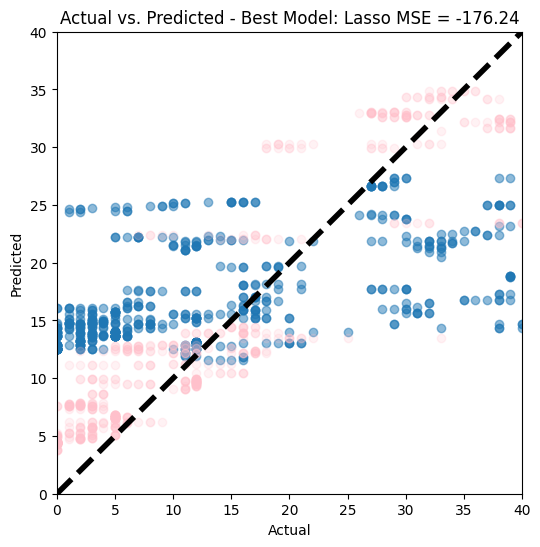

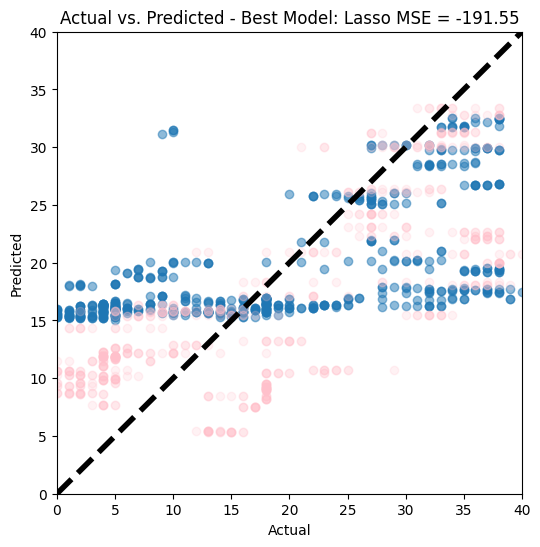

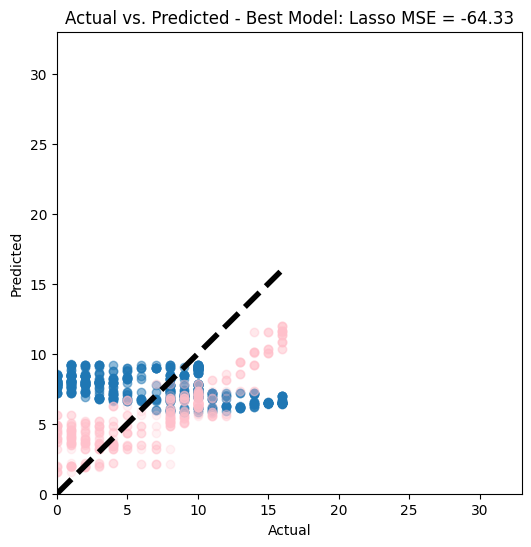

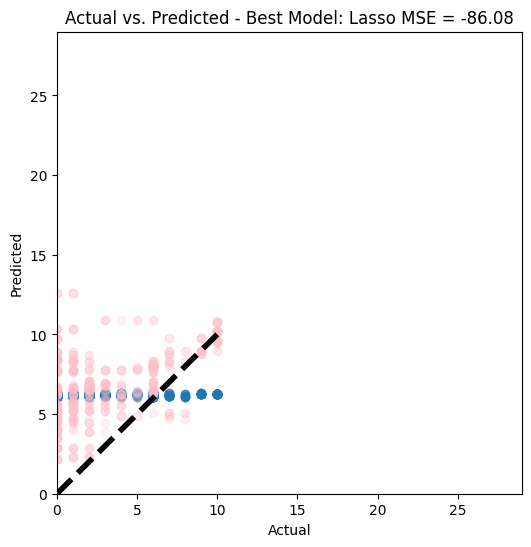

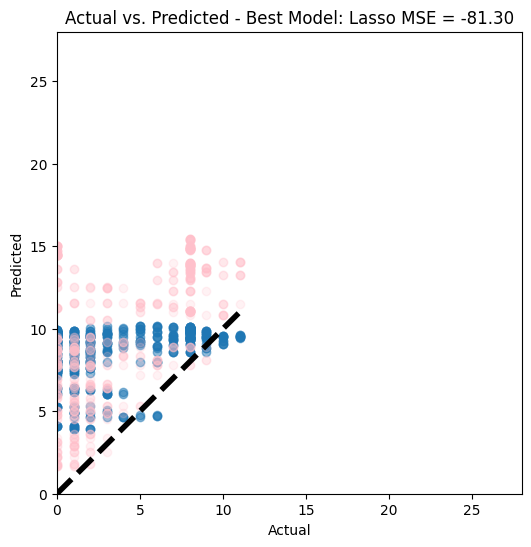

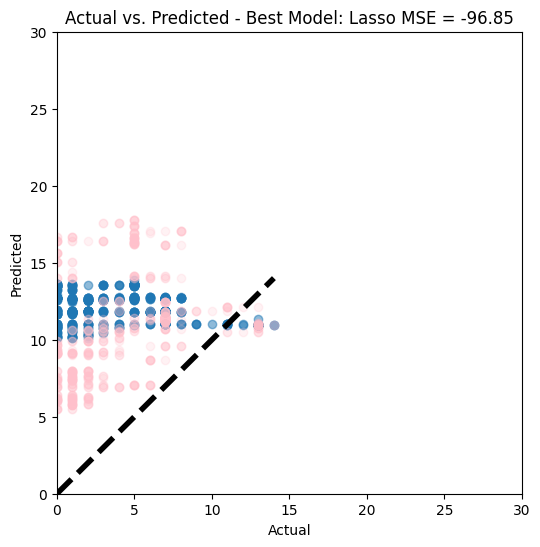

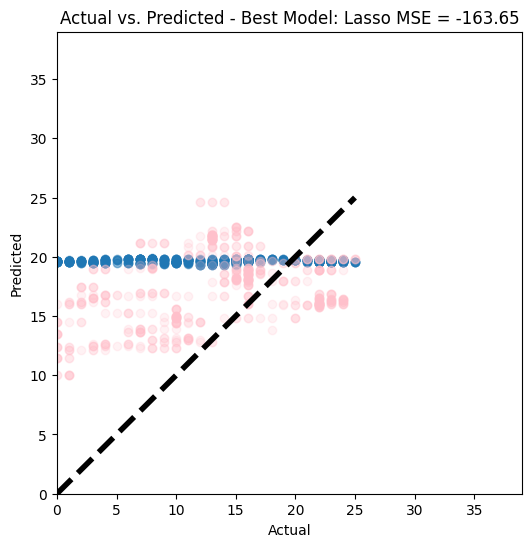

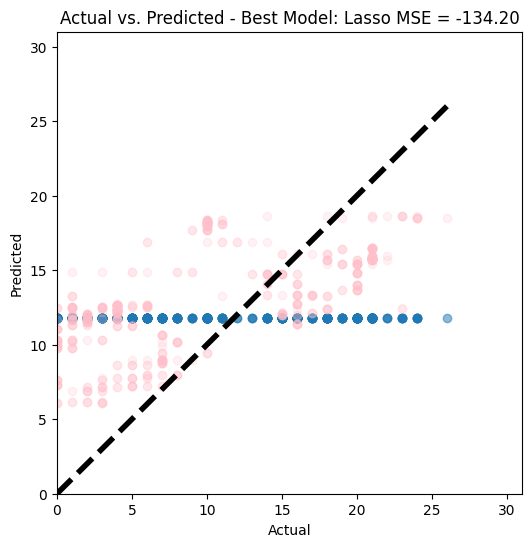

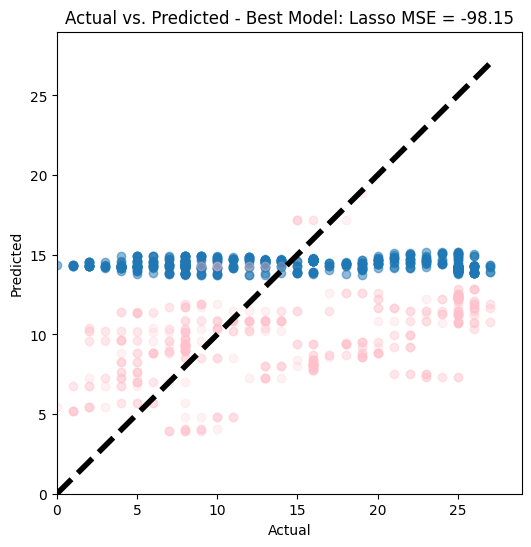

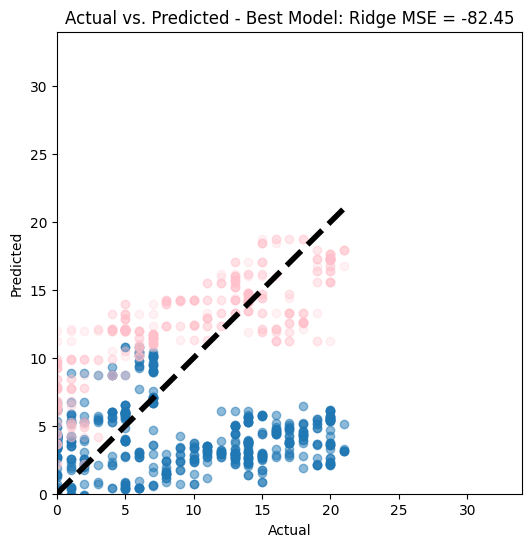

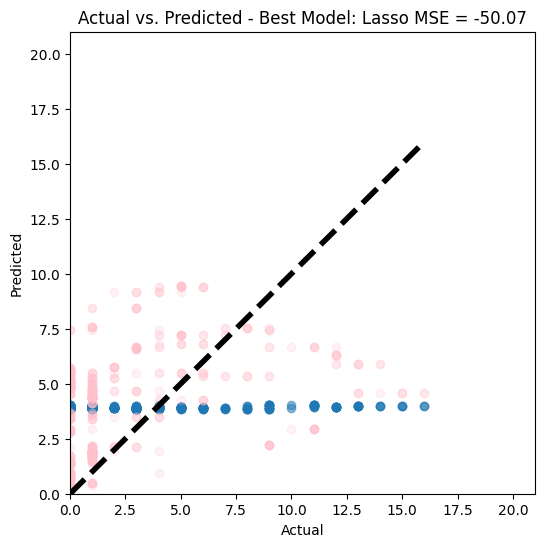

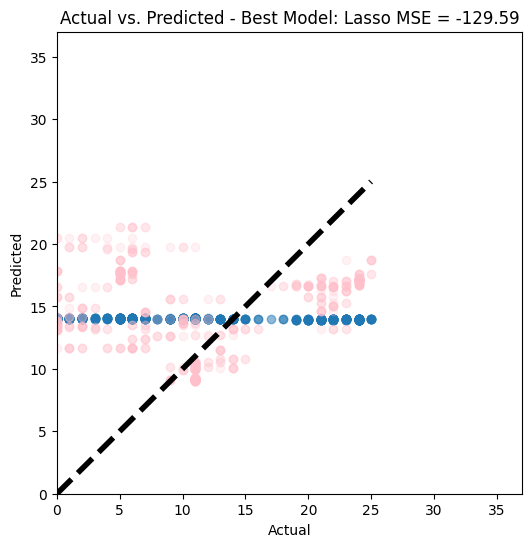

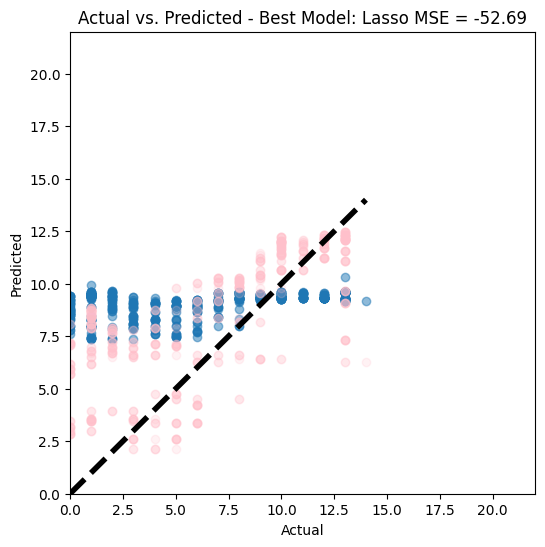

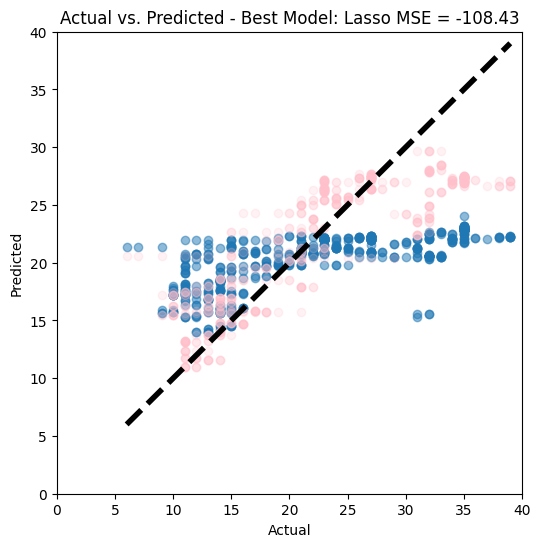

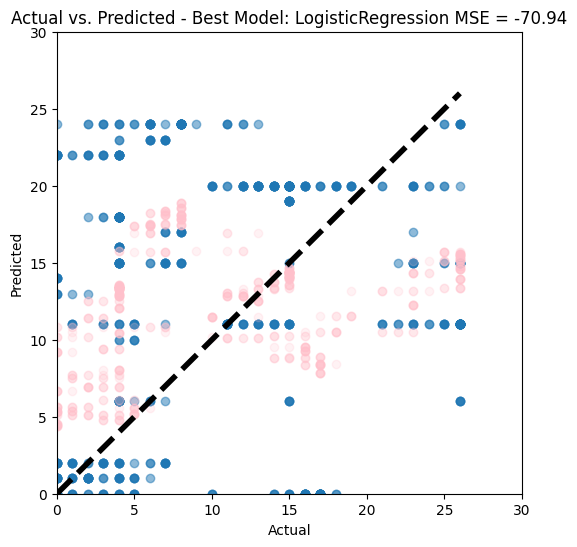

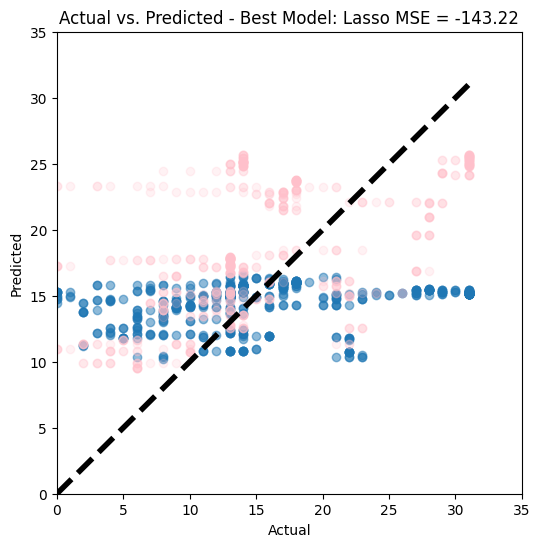

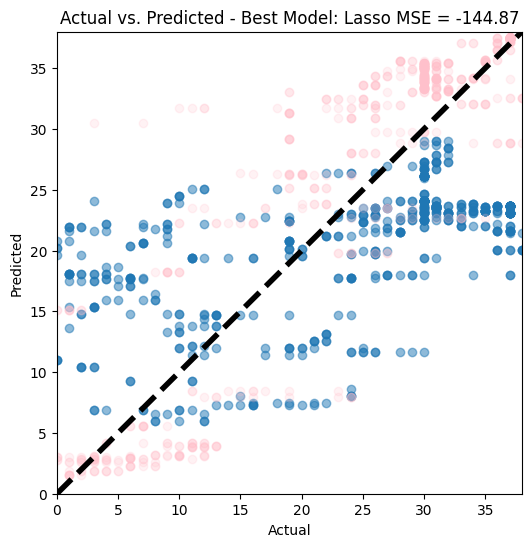

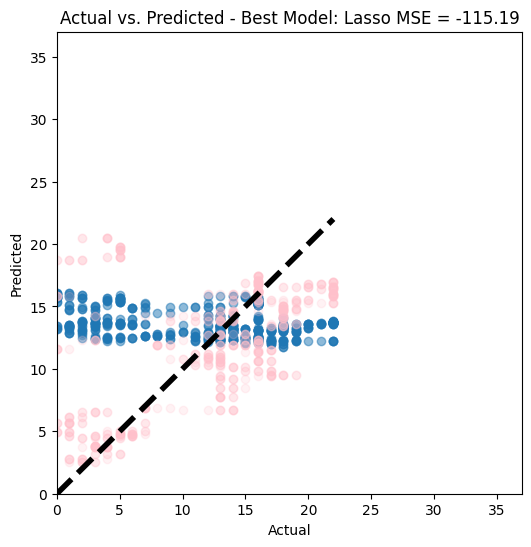

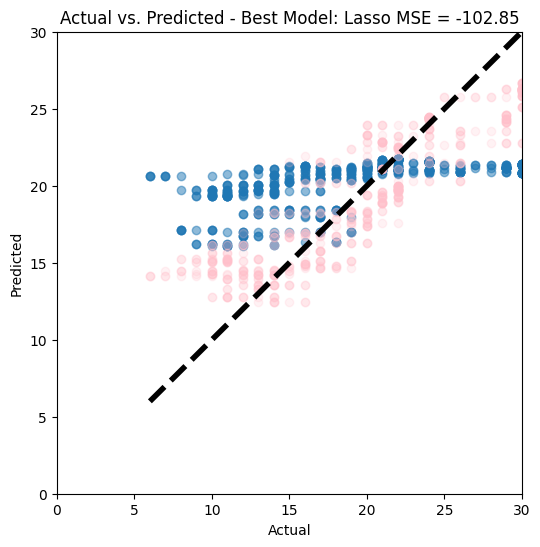

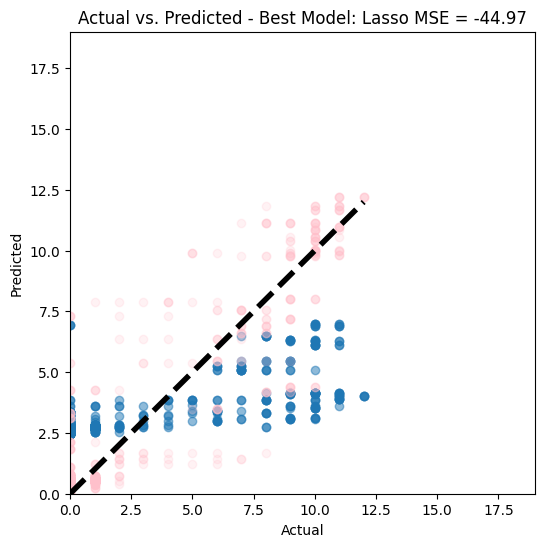

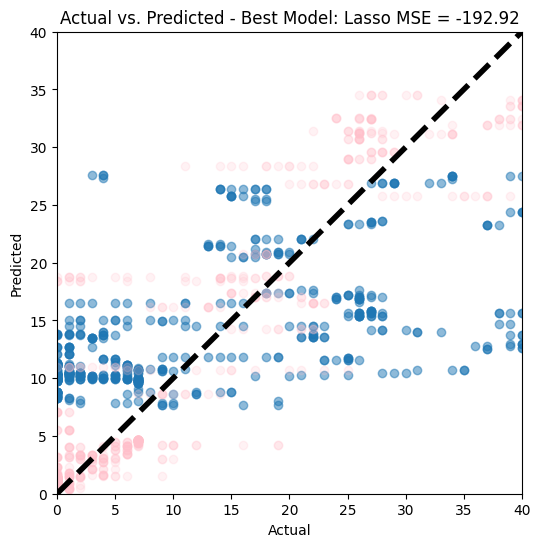

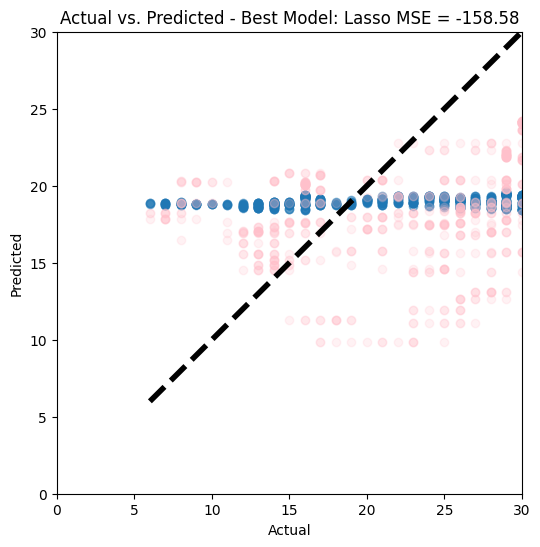

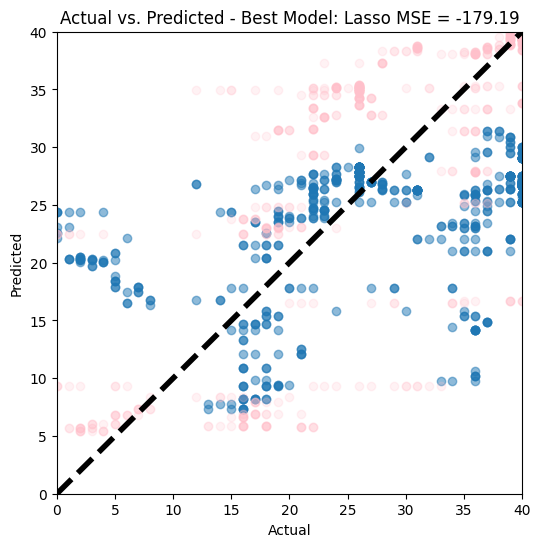

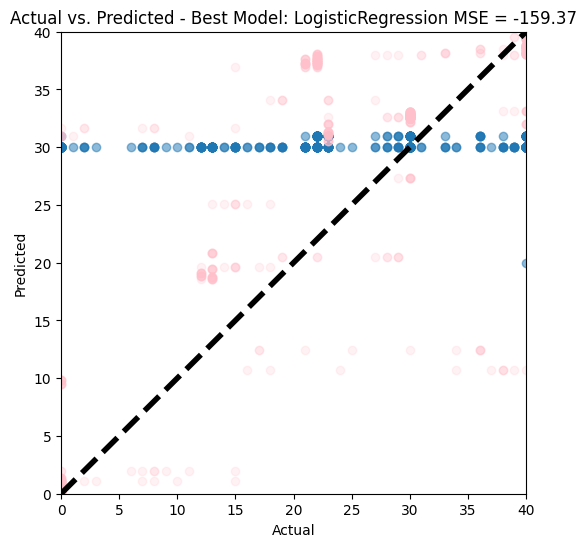

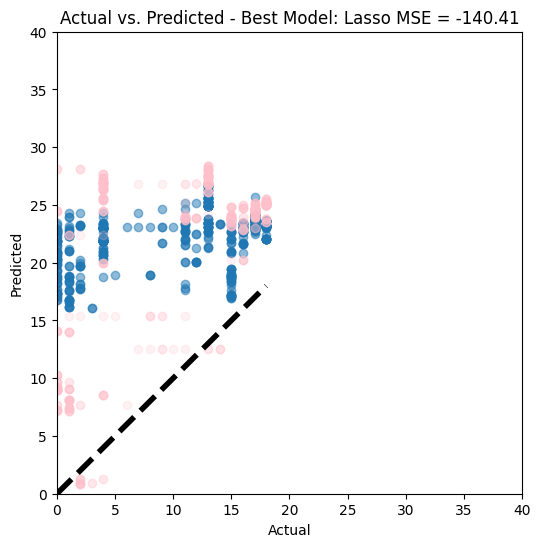

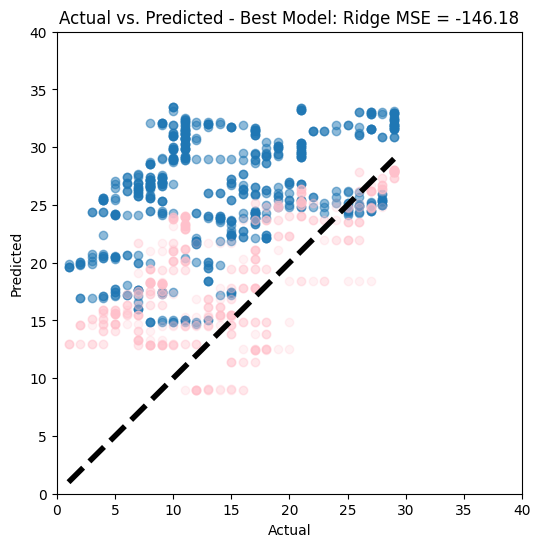

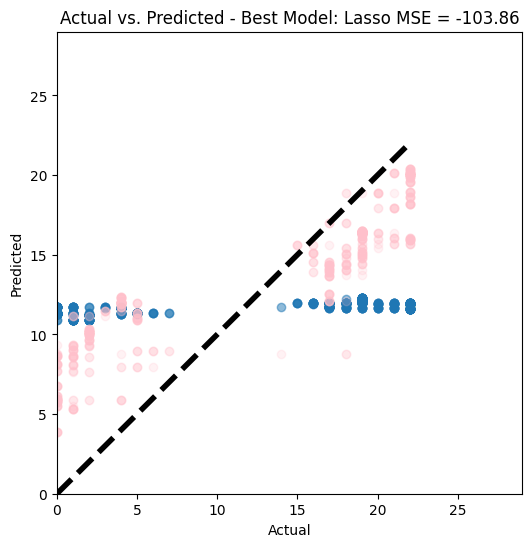

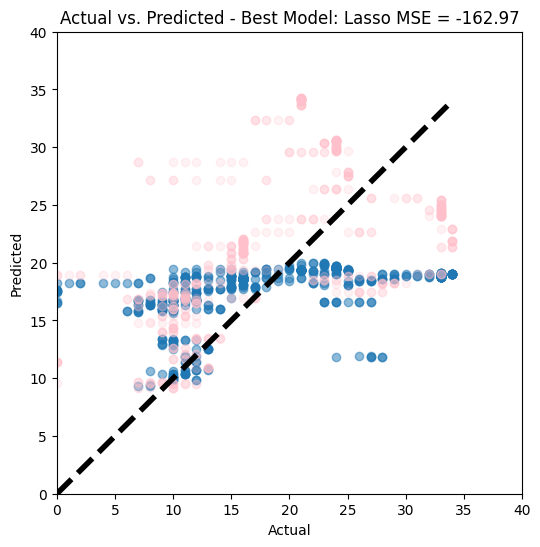

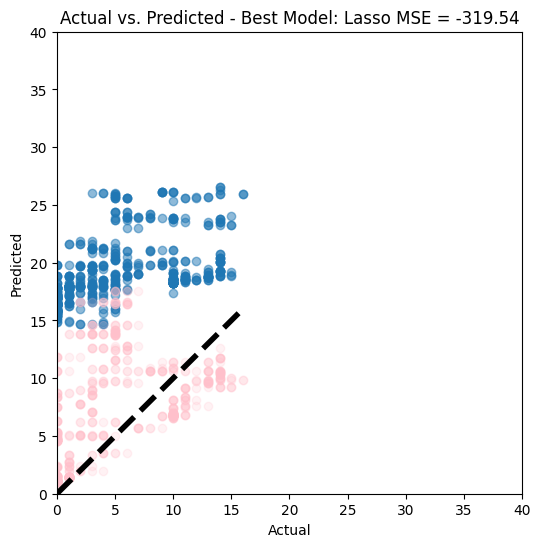

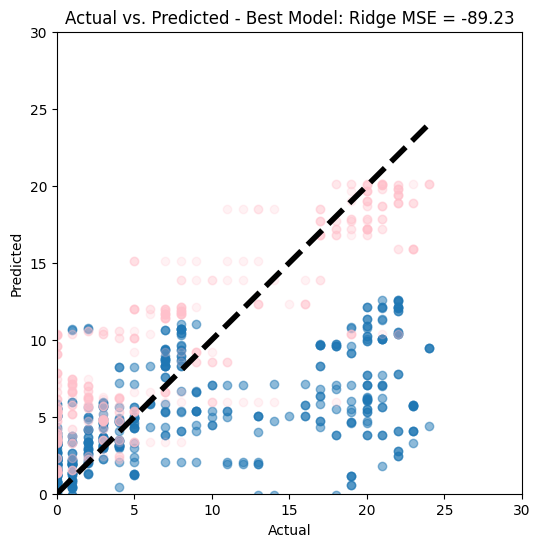

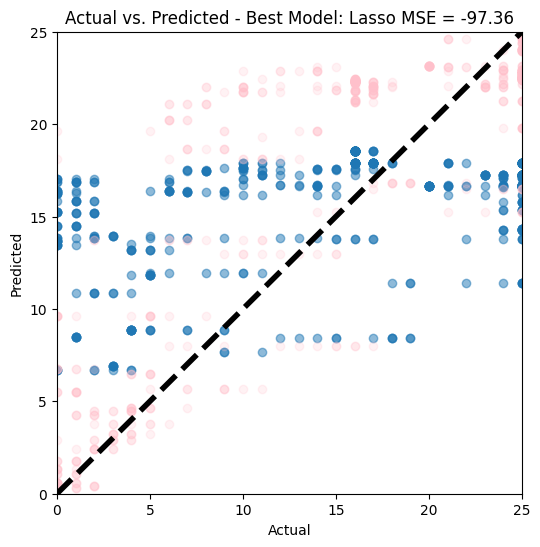

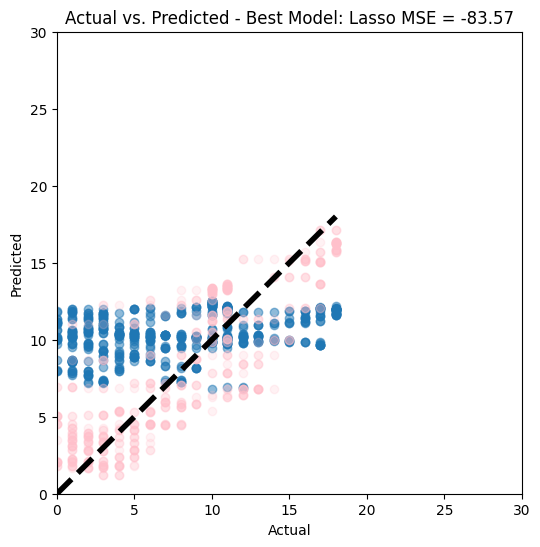

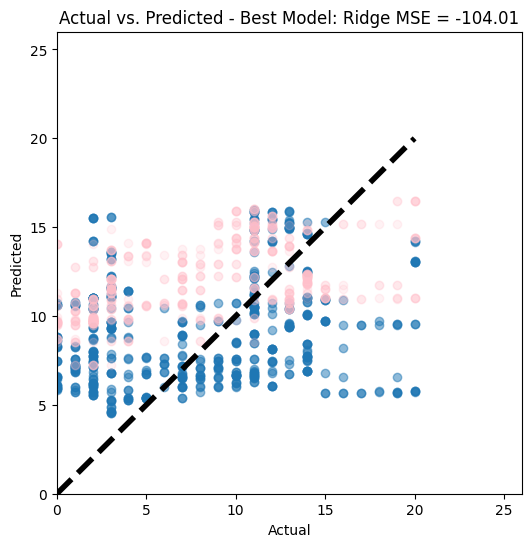

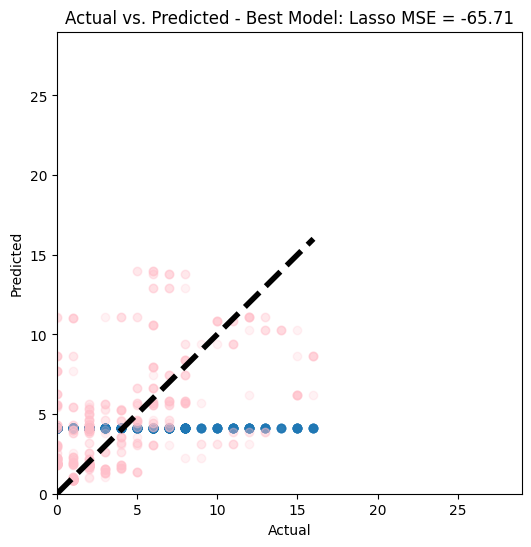

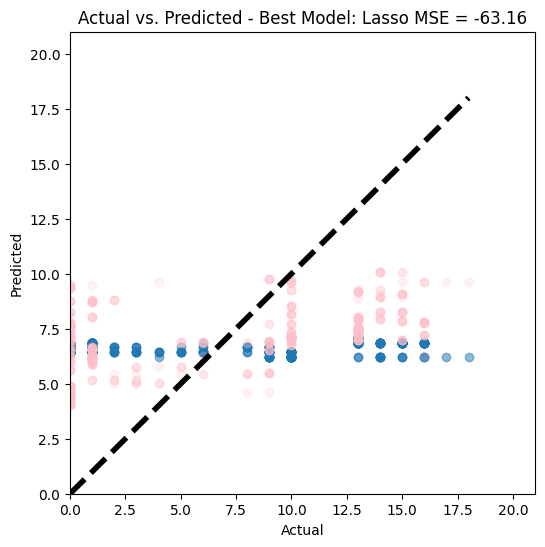

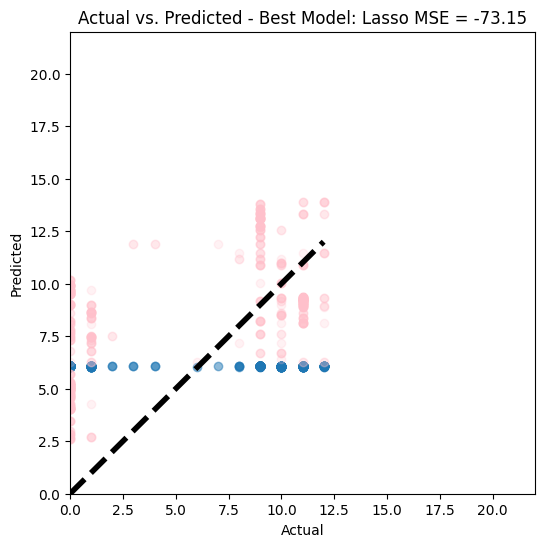

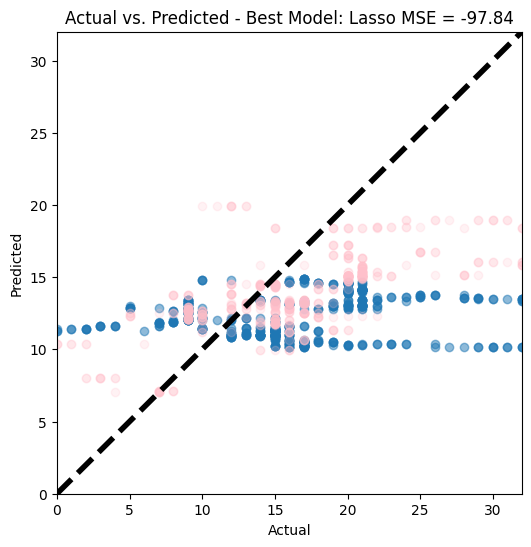

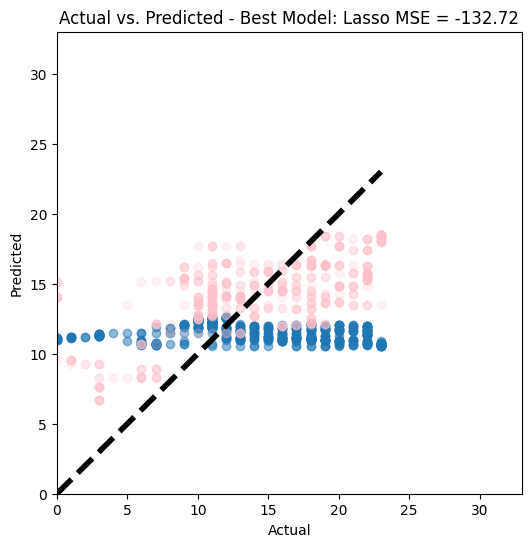

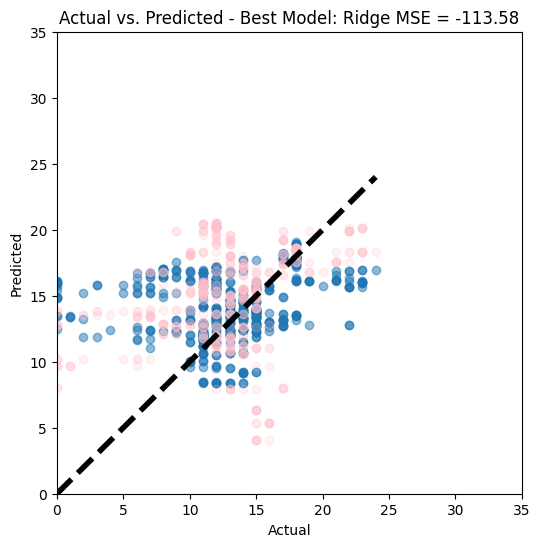

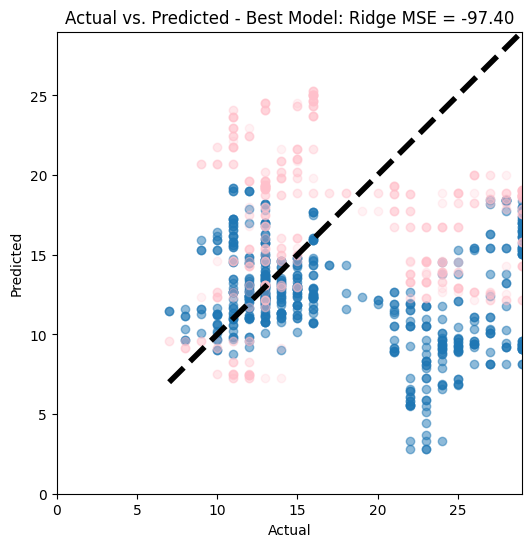

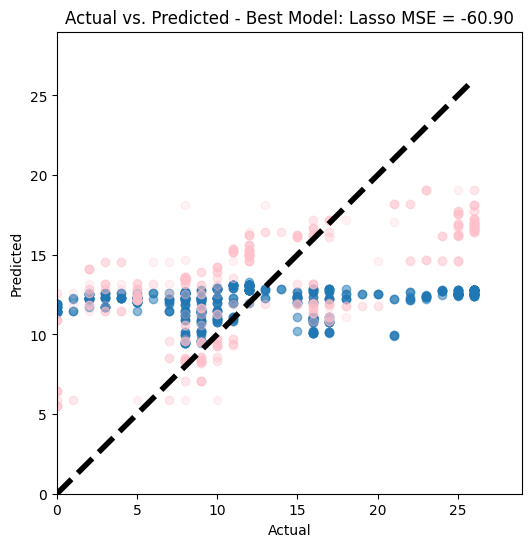

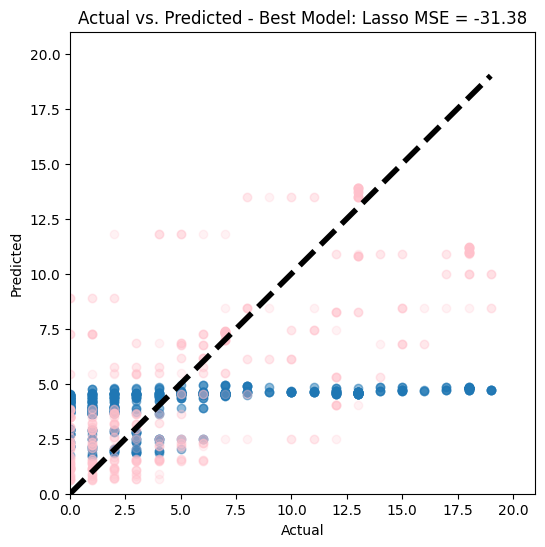

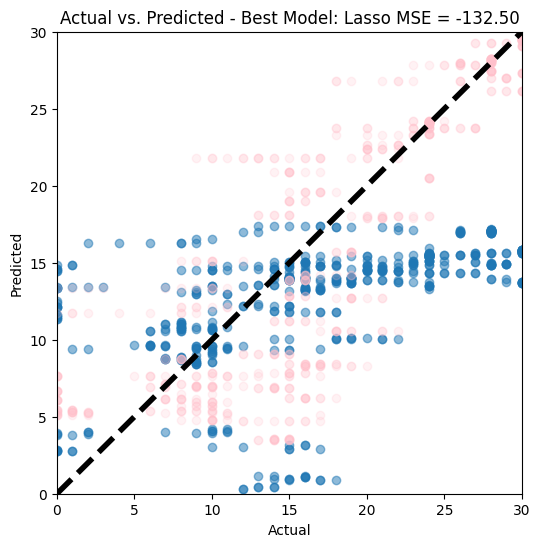

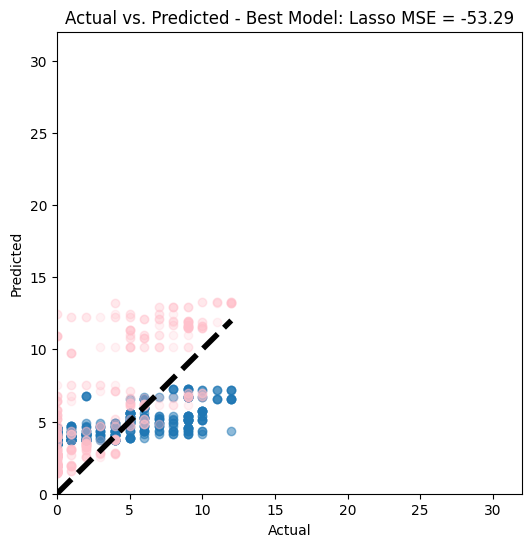

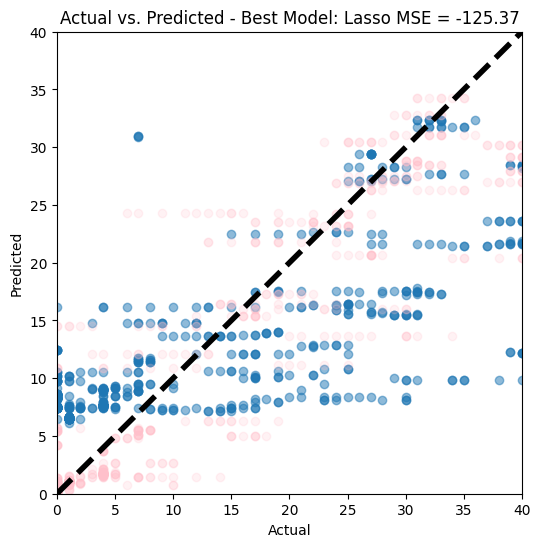

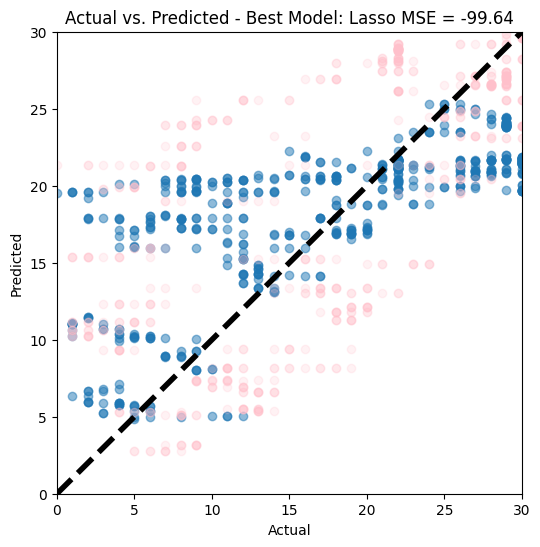

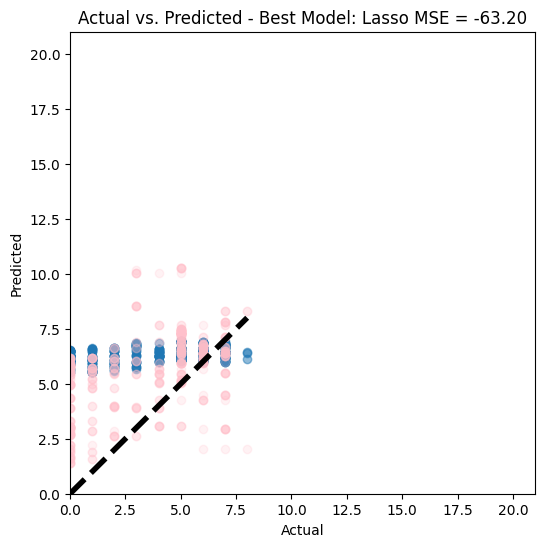

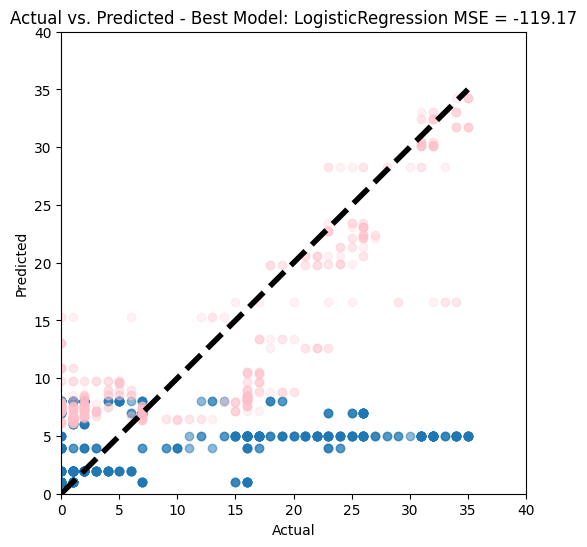

In [9]:
for i in set(df.number):
    df_i = df.loc[df['number'] == i]
    addHourDayMonth(df_i)
    y = df_i['available_bikes']
    X = df_i.drop(['available_bikes'], axis=1)
    
    # Handling categorical variables and missing values
    categorical_features = ["number",'weather_main', 'weather_description',"banking"]
    numerical_features = X.drop(columns=categorical_features).columns
    
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ])

    # Number of points to be used as test data
    test_size = 600
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]    
    models = {
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Linear Regression': LinearRegression(),
        'LogisticRegression':LogisticRegression(),
        # "BayesianRidge":BayesianRidge()
        # 'LinearSVR':LinearSVR()
        # "RandomForestRegressor": RandomForestRegressor()
    }
    model_pipelines = {}
    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        model_pipelines[name] = pipeline
    model_scores = {}
    for name, pipeline in model_pipelines.items():
        # Using negative MSE to make it easier to compare (higher is better)
        scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
        model_scores[name] = scores.mean()
    
    best_model_name = max(model_scores, key=model_scores.get)
    best_pipeline = model_pipelines[best_model_name]
    
    # Fit and predict using the best model
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    
    #Baseline Model
    averages = df_i.groupby(['number', 'day_of_week', 'hour'])['available_bikes'].mean().reset_index()
    y_pred_avg = pd.merge(X_test, averages, on=['number', 'day_of_week', 'hour'], how='left')['available_bikes']
    
    # Visualization
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.scatter(y_test, y_pred_avg, alpha=0.2,color = 'pink')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.xlim(0,max(df_i['available_bikes']))
    plt.ylim(0,max(df_i['available_bikes']))
    plt.title(f'Actual vs. Predicted - Best Model: {best_model_name} MSE = {model_scores[name]:.2f}')
    plt.savefig(f'plots/{i}-{best_model_name}.png')
    joblib.dump(best_pipeline, f'models/{i}.joblib')

import csv

# After the model evaluation
mse = -model_scores[best_model_name]  # Convert negative MSE back to positive
features_used = ' '.join(categorical_features + list(numerical_features))

# CSV file path
csv_file_path = 'model_records.csv'

# Open the CSV file in append mode and write the model details
with open(csv_file_path, 'a', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Check if the file is empty to write the header
    csvfile.seek(0, 2)  # Move the cursor to the end of the file
    if csvfile.tell() == 0:  # If file is empty, write the header
        csvwriter.writerow(['Model Name', 'MSE', 'Features Used'])
    csvwriter.writerow([best_model_name, mse, features_used])

Inference:

In [ ]:
from datetime import datetime
import requests
import json

OpenWeather_api_key = "6ac1c4119c9a1919193d6b37a98a9b0b"

In [ ]:
dtForecast = int(datetime.strptime("2024-03-08T12:20:38Z", "%Y-%m-%dT%H:%M:%SZ").timestamp())

In [ ]:
weatherResponse = requests.get(f"https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={53}&lon={-6}&dt={dtForecast}&appid={OpenWeather_api_key}")

In [ ]:
def parse_item(item):
    rain = item.get('rain', {'1h': None}).get('1h')
    snow = item.get('snow', {'1h': None}).get('1h')
    weather_main = item['weather'][0]['main'] if 'weather' in item and item['weather'] else None
    weather_description = item['weather'][0]['description'] if 'weather' in item and item['weather'] else None
    return {
        'dt': item.get('dt'),
        'sunrise': item.get('sunrise'),
        'sunset': item.get('sunset'),
        'temp': item.get('temp'),
        'feels_like': item.get('feels_like'),
        'pressure': item.get('pressure'),
        'humidity': item.get('humidity'),
        'uvi': item.get('uvi'),
        'clouds': item.get('clouds'),
        'visibility': item.get('visibility'),
        'wind_speed': item.get('wind_speed'),
        'wind_deg': item.get('wind_deg'),
        'wind_gust': item.get('wind_gust'),
        'weather_main': weather_main,
        'weather_description': weather_description,
        'rain': rain,
        'snow': snow
    }

weatherJson = json.loads(weatherResponse.text)
weather = parse_item(weatherJson['data'][0])

In [ ]:
station = {"number":13, "last_update":pd.to_datetime(dtForecast,unit='s'),"banking":0}
X_infer = pd.DataFrame.from_dict([station|weather])

In [ ]:
filtered_features = [feature for feature in featuresList if feature in X_infer.columns]
X_infer = X_infer[filtered_features]

In [ ]:
addHourDayMonth(X_infer)

In [ ]:
X_infer

In [ ]:
bestModel = joblib.load('BestModel.joblib')

In [ ]:
bestModel.predict(X_infer)